In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.style.use('ggplot')

# Args

In [3]:
EXP = "exp3/"
PRJ = "specificity_matrix/"

## Plotting directory

In [4]:
FIG_DIR = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/plots/" + EXP + PRJ
TAB_DIR = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/tables/" + EXP

In [5]:
FIG_SUND = "/Volumes/sund/Public/T-cells-and-cancer/herpov/plots/" + EXP + PRJ
TAB_SUND = "/Volumes/sund/Public/T-cells-and-cancer/herpov/tables/" + EXP + PRJ

## GEM list

In [6]:
GEM_LISTS = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp3_MHC/gem_lists/"

## Input data

In [7]:
response_annotations = "/Volumes/tuba/herpov/tcr-pmhc-sc-project/data/exp3_MHC/barcode_library/detected_responses_annotation.xlsx"

# Import input data

In [8]:
clonotype_barcode_specificity_df = pd.read_csv(TAB_DIR + "tcr_barcode_annotations.csv")

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1,2,3,4,5,8,9,10,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
response_df = pd.read_excel(response_annotations, index_col=None, usecols=['barcode_cd8', 'num_sorted_cells', 'peptide', 'est_freq'])

In [10]:
print(clonotype_barcode_specificity_df.shape)
print(clonotype_barcode_specificity_df.gem.unique().shape)
print(clonotype_barcode_specificity_df.dropna(subset=['gem', 'clonotype', 'template_id_mhc']).shape)

(6385, 143)
(6385,)
(2011, 143)


# Preprocessing

In [11]:
credible_df = clonotype_barcode_specificity_df[(clonotype_barcode_specificity_df.credible_alignment_mhc == True)].copy()
credible_df['num_clonotype'] = pd.to_numeric(credible_df['clonotype'].fillna('None').str.split('clonotype').str[1], errors='coerce').replace(np.nan, 0, regex=True).astype(int)

In [12]:
print(credible_df.shape)
print(credible_df.gem.unique().shape)
print(credible_df.dropna(subset=['gem', 'clonotype', 'template_id_mhc']).shape)
print(credible_df.dropna(subset=['gem', 'clonotype', 'template_id_mhc']).gem.unique().shape)

(5687, 144)
(5687,)
(2011, 144)
(2011,)


## Cleaning dataframe
Remove clonotype NaN, None, 0. Remove epitope 0.

In [13]:
credible_df.drop(credible_df[credible_df.num_clonotype == 0].index, inplace=True)
credible_df.drop(credible_df[credible_df.epitope == '0'].index, inplace=True)
credible_df.drop(credible_df[credible_df.epitope == 'Unnamed: 39'].index, inplace=True)

In [14]:
print(credible_df.shape)
print(credible_df.gem.unique().shape)

(1854, 144)
(1854,)


## Binding concordance

In [15]:
def calc_binding_concordance(df):
    assert df.size > 0, "df empty"
    gems_per_specificity_df = df.groupby(['clonotype','epitope']).gem.count().to_frame().reset_index()
    gems_per_specificity_df.rename(columns={'gem': 'gems_per_specificity'}, inplace=True)
    
    gems_per_clonotype_df = df.groupby(['clonotype']).gem.count().to_frame().reset_index()
    gems_per_clonotype_df.rename(columns={'gem': 'gems_per_clonotype'}, inplace=True)
    
    df = pd.merge(df, gems_per_specificity_df, on=['clonotype', 'epitope'], how='left').merge(gems_per_clonotype_df, on='clonotype', how='left')
    df['binding_concordance'] = df.gems_per_specificity / df.gems_per_clonotype
    
    return df

## Annotate GEMs with single/multiple T-cells

In [16]:
credible_df['single_tcell'] = np.where((credible_df.single_TRA) & (credible_df.single_TRB), True, False)

## Annotate GEMs when peptide has been assayed

In [17]:
credible_df['peptide_assayed'] = np.where(credible_df.peptide.isin(response_df.peptide), True, False)

## Computing sum of TRA and TRB UMIs

In [18]:
credible_df['umis_tcr'] = credible_df.umis_TRA.values + credible_df.umis_TRB.values

## Produce y-tick labels

In [19]:
credible_df['peptide_HLA'] = credible_df.peptide.str.split('_').str[0] + ' ' + credible_df.HLA

## Sanity check

In [20]:
# Only include GEMs where there is a single clonotype 
if not credible_df.groupby(['gem']).clonotype.nunique().eq(1).all():
    print(credible_df.groupby(['gem']).clonotype.nunique().eq(1))

In [21]:
print(credible_df.shape)
print(credible_df.gem.unique().shape)

(1854, 148)
(1854,)


## Write GEMs to list

In [26]:
np.savetxt(GEM_LISTS + "credible_df.lst",
           credible_df.gem.values, fmt='%s')

In [28]:
np.savetxt(GEM_LISTS + "credible_df.min10.lst",
           credible_df[credible_df.read_counts_mhc >= 10].gem.values, fmt='%s')

# Peptide per GEM

### GEM to clonotype

In [57]:
sortby = 'num_clonotype'
credible_df.sort_values(by=[sortby], inplace=True)

In [58]:
gem_to_clonotype = dict()

for gem in credible_df.gem.unique():
    clonotypes = credible_df[credible_df.gem == gem].clonotype.values
    
    assert len(np.unique(clonotypes)) == 1, print(clonotypes, gem)
    #assert 'clonotype' in clonotypes[0], print(clonotypes)
    
    gem_to_clonotype[gem] = clonotypes[0]
    
#for gem in specificity_matrix.index.to_list():
#    if not gem in gem_to_clonotype:
#        gem_to_clonotype[gem] = 'None'

### Clonotype to color

In [59]:
all_clonotypes = credible_df.clonotype.unique()
col_clonotypes = ['#9e0142','#d53e4f','#f46d43','#fdae61','#fee08b','#ffffbf','#e6f598','#abdda4','#66c2a5','#3288bd','#5e4fa2'] * len(all_clonotypes)

clonotype_to_color = dict()
for i, clonotype in enumerate(all_clonotypes):
    clonotype_to_color[clonotype] = col_clonotypes[i]

### Plot

In [60]:
import matplotlib as mpl
mpl.rcParams['axes.grid.axis'] = 'y'

project = "peptide_per_gem/"
version = 5
read_threshold = 1
tcr_threshold = 1
exclude_clonotype_singlets = False
exclude_specificity_singlets = False

for read_threshold in [1, 10, 20, 50]:
    for tcr_threshold in [1, 10, 20, 50]:
        for exclude_clonotype_singlets in [True, False]:
            for exclude_specificity_singlets in [True, False]:

                unique_gems = set()

                fig, ax = plt.subplots(figsize=(20, 10))

                for mhc_barcode in credible_df.peptide_HLA.unique(): #credible_df.epitope.unique(): #specificity_df.columns:
                    #if mhc_barcode == '0':
                    #    continue

                    sub_df = credible_df[(credible_df.peptide_HLA == mhc_barcode) &
                                         (credible_df.read_counts_mhc >= read_threshold) &
                                         (credible_df.umis_tcr >= tcr_threshold)].copy()
                    if exclude_clonotype_singlets:
                        sub_df.drop(sub_df[~sub_df.duplicated(subset='num_clonotype', keep=False)].index, inplace=True)
                    if exclude_specificity_singlets:
                        sub_df.drop(sub_df[~sub_df.duplicated(subset=['num_clonotype', 'epitope'], keep=False)].index, inplace=True)

                    gems = sub_df.gem.values
                    mhcs = [mhc_barcode] * len(gems)
                    reads = sub_df.read_counts_mhc.values

                    clonotypes = np.array([gem_to_clonotype[gem] for gem in gems])

                    #none_indexes = np.where(clonotypes == 'None')
                    #gems = np.delete(gems, none_indexes)
                    #mhcs = np.delete(mhcs, none_indexes)
                    #reads = np.delete(reads, none_indexes)
                    #clonotypes = np.delete(clonotypes, none_indexes)

                    colors = [clonotype_to_color[ct] for ct in clonotypes]

                    unique_gems.update(sub_df.gem.to_list())

                    scatter = ax.scatter(gems, mhcs, s=reads, c=colors, edgecolors='face') #, alpha=0.3

                #total_gems = ax.get_xticklabels()
                plt.xlabel("%i GEMs" %len([item.get_text() for item in ax.get_xticklabels()]), fontsize=16)
                plt.tick_params(labelbottom=False, labelright=True, labelsize=8) #8

                # Criteria
                textstr = '\n'.join((
                    "Criteria",
                    "Min. barcode read count \t %i".expandtabs() %read_threshold,
                    "Min. TCR read count \t\t    %i".expandtabs() %tcr_threshold,
                    "Exclude clonotype singlets \t %s".expandtabs() %str(exclude_clonotype_singlets),
                    "Exclude specificity singlets \t   %s".expandtabs() %str(exclude_specificity_singlets)))
                props = dict(boxstyle='square', fc='white', ec='grey', alpha=0.5)
                #textstr = '\n'.join(("test \t test".expandtabs(),"test \t %i".expandtabs() %(read_threshold),"tester \t test".expandtabs()))
                ax.text(0.05, 0.95, textstr,
                        fontsize=12,
                        horizontalalignment='left',
                        verticalalignment='top',
                        clip_on=False,
                        transform=ax.transAxes,
                        bbox=props)

                from matplotlib.lines import Line2D

                legend_elements = []
                for clonotype_label in all_clonotypes:
                    legend_elements += [Line2D([0], [0], marker='o', color='w', label=clonotype_label, markerfacecolor=clonotype_to_color[clonotype_label], markersize=10)]

                legend1 = ax.legend(handles=legend_elements, ncol=9, loc=2, bbox_to_anchor=(0.02, -0.03))
                ax.add_artist(legend1)

                for read_size in [10, 50, 100]:
                    plt.scatter([], [], c='k', alpha=0.3, s=read_size, label=str(read_size) + ' reads')
                plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Barcode reads', loc='lower right')


                plt.ylabel("Peptide, HLA", fontsize=16)
                plt.title("Peptide specificity per GEM", fontsize=20)
                plt.savefig(FIG_DIR + project + "v%i.b%i.t%i.ecs_%s.ess_%s.sortby_%s.pdf" %(version, read_threshold, tcr_threshold, exclude_clonotype_singlets, exclude_specificity_singlets, sortby), bbox_inches='tight')
                plt.savefig(FIG_SUND + project + "v%i.b%i.t%i.ecs_%s.ess_%s.sortby_%s.pdf" %(version, read_threshold, tcr_threshold, exclude_clonotype_singlets, exclude_specificity_singlets, sortby), bbox_inches='tight')
                #plt.show()
                plt.cla()   # Clear axis
                plt.clf()   # Clear figure
                plt.close(fig) # Close a figure window
                #print(len(unique_gems))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/anaconda3/lib/python3.7/site-packages/ipyker

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/anaconda3/lib/python3.7/site-packages/ipyker

In [72]:
unique_gems_1 = unique_gems

In [216]:
credible_df[credible_df.epitope == 'CLYBL'][['clonotype', 'cdr3_TRA', 'cdr3_TRB', 'umis_TRA', 'umis_lst_TRA', 'umis_TRB', 'umis_lst_TRB', 'read_counts_lst_mhc', 'template_lst_mhc']] #, 'read_counts_lst_cd8', 'template_lst_cd8'

clonotype           cdr3_TRA            cdr3_TRB  umis_TRA  \
749     clonotype1  CAVRSAYSGAGSYQLTF    CASRPRVAGGRNEQFF      42.0   
606     clonotype1  CAVRSAYSGAGSYQLTF    CASRPRVAGGRNEQFF      42.0   
651     clonotype1  CAVRSAYSGAGSYQLTF    CASRPRVAGGRNEQFF      48.0   
4       clonotype1  CAVRSAYSGAGSYQLTF    CASRPRVAGGRNEQFF      33.0   
172     clonotype1  CAVRSAYSGAGSYQLTF    CASRPRVAGGRNEQFF      42.0   
518     clonotype1  CAVRSAYSGAGSYQLTF    CASRPRVAGGRNEQFF      48.0   
746     clonotype1  CAVRSAYSGAGSYQLTF    CASRPRVAGGRNEQFF      32.0   
682     clonotype2   CAAKSDSGGGADGLTF     CASSAWTSNRDEQFF       2.0   
110     clonotype2   CAAKSDSGGGADGLTF     CASSAWTSNRDEQFF       3.0   
449     clonotype2   CAAKSDSGGGADGLTF     CASSAWTSNRDEQFF       8.0   
106     clonotype2   CAAKSDSGGGADGLTF     CASSAWTSNRDEQFF       5.0   
209     clonotype2   CAAKSDSGGGADGLTF     CASSAWTSNRDEQFF       7.0   
156     clonotype2   CAAKSDSGGGADGLTF     CASSAWTSNRDEQFF      16.0   
617     clonotype2   CAAKSDSGGGADGLTF     CASSAWTSNRDEQFF       6.0   
166     clonotype2   CAAKSDSGGGADGLTF     CASSAWTSNRDEQFF       5.0   
563     clonotype2   CAAKSDSGGGADGLTF     CASSAWTSNRDEQFF       8.0   
560     clonotype2   CAAKSDSGGGADGLTF     CASSAWTSNRDEQFF      11.0   
536     clonotype2   CAAKSDSGGGADGLTF     CASSAWTSNRDEQFF       7.0   
578     clonotype2   CAAKSDSGGGADGLTF     CASSAWTSNRDEQFF      10.0   
619     clonotype2   CAAKSDSGGGADGLTF     CASSAWTSNRDEQFF      12.0   
194     clonotype2   CAAKSDSGGGADGLTF     CASSAWTSNRDEQFF       4.0   
498     clonotype2   CAAKSDSGGGADGLTF     CASSAWTSNRDEQFF      24.0   
641     clonotype2   CAAKSDSGGGADGLTF     CASSAWTSNRDEQFF       4.0   
132     clonotype2   CAAKSDSGGGADGLTF     CASSAWTSNRDEQFF       5.0   
500     clonotype2   CAAKSDSGGGADGLTF     CASSAWTSNRDEQFF       2.0   
620     clonotype2   CAAKSDSGGGADGLTF     CASSAWTSNRDEQFF       7.0   
136     clonotype2   CAAKSDSGGGADGLTF     CASSAWTSNRDEQFF       6.0   
635     clonotype2   CAAKSDSGGGADGLTF     CASSAWTSNRDEQFF      11.0   
629     clonotype2   CAAKSDSGGGADGLTF     CASSAWTSNRDEQFF       6.0   
144     clonotype2   CAAKSDSGGGADGLTF     CASSAWTSNRDEQFF       5.0   
..             ...                ...                 ...       ...   
91    clonotype254      CAVLPDSNYQLIW      CASNQGGNTGELFF      13.0   
186   clonotype327     CAARQLEYGNKLVF    CASSGQQSSGANVLTF      13.0   
740   clonotype357     CAGPLYNQGGKLIF     CSARDLGTLYVEQYF      24.0   
175   clonotype389    CAESWTNTGFQKLVF  CASSYSQVGARVNEKLFF       1.0   
206   clonotype402       CADSNAGNMLTF        CASSSGGGEQFF      12.0   
405   clonotype453   CAEKLDRGSTLGRLYF        CASSLRRDGEFF       3.0   
54    clonotype658       CAPIYNTDKLIF      CSVVTGPVLYGYTF       5.0   
83    clonotype745      CAVRVNSGYALNF     CSALGTRSNTDTQYF       6.0   
259  clonotype1190    CAVLGGFSGNTPLVF    CASSQPGVLYNSPLHF       2.0   
260  clonotype1192    CLVGDGGGGYNKLIF       CASSLASAYEQYF       5.0   
285  clonotype1253          CGQGDKLIF     CASSPQGASNEKLFF       5.0   
388  clonotype1476    CAMSVITDSWGKLQF       CASSTGQAYEQYF       3.0   
429  clonotype1533      CAGASDSWGKLQF       CASSPRVYGELFF       5.0   
450  clonotype1591   CAAKSDSGGGADGLTF     CASSAWTSNRDEQFF       8.0   
480  clonotype1688   CAVKSDSGGGADGLTF     CASSAWTSNRDEQFF       4.0   
488  clonotype1705   CAAKSDSGGGADGLTF     CASSAWTSNRDEQFF       8.0   
509  clonotype1723     CAMPNSGGYQKVTF      CASDKTGTSYEQYF       3.0   
517  clonotype1742    CAMREDPQGAQKLVF      CASSQSYDSYEQYF      23.0   
528  clonotype1779    CLVGDVRGGGNKLTF         CASSQGDGYTF       2.0   
541  clonotype1809       CAERDSWGKFQF      CSGDLGRQNTEAFF       3.0   
598  clonotype1947   CAMREDYTGANSKLTF    CASSLIRDRGRQPQHF       5.0   
604  clonotype1969       CAASANDYKLSF    CASSFPAGGPYNEQFF      54.0   
625  clonotype2013      CASVVNTGNQFYF    CASSPLAGDLRSGQFF       3.0   
648  clonotype2069       CALNTGGFKTIF     CASSAWTSNRDEQFF       9.0   
723  clonotype2246      CAYSFSGTY

# Peptide per clonotype (GEM counts)

In [77]:
sortby = 'clonotype'
credible_df.sort_values(by=[sortby], inplace=True)

In [78]:
import matplotlib as mpl
mpl.rcParams['axes.grid.axis'] = 'both'#y

project = "peptide_per_clonotype_by_gem_size/"
version = 4
read_threshold = 10
tcr_threshold = 10
concordance_threshold = 0.6
exclude_clonotype_singlets = False
exclude_specificity_singlets = False

for read_threshold in [1, 10, 20, 50]:
    for tcr_threshold in [1, 10, 20, 50]:
        for exclude_clonotype_singlets in [True, False]:
            for exclude_specificity_singlets in [True, False]:
                
                unique_gems = set()

                fig, ax = plt.subplots(figsize=(20, 10))

                for mhc_barcode in credible_df.peptide_HLA.unique(): #credible_df.epitope.unique(): #specificity_df.columns:

                    sub_df = credible_df[(credible_df.read_counts_mhc >= read_threshold) &
                                         (credible_df.umis_tcr >= tcr_threshold)].copy()
                    if exclude_clonotype_singlets:
                        sub_df.drop(sub_df[~sub_df.duplicated(subset='num_clonotype', keep=False)].index, inplace=True)
                    if exclude_specificity_singlets:
                        sub_df.drop(sub_df[~sub_df.duplicated(subset=['num_clonotype', 'epitope'], keep=False)].index, inplace=True)

                    sub_df = calc_binding_concordance(sub_df)
                    sub_df = sub_df[sub_df.peptide_HLA == mhc_barcode]
                    
                    tcrs = sub_df.clonotype.str.split('clonotype').str[1].unique()
                    mhcs = [mhc_barcode] * len(tcrs)
                    gems = sub_df.groupby(['clonotype']).gems_per_specificity.mean().values * 10 #groupby(['clonotype']).gem.count().values
                    colors = sub_df.groupby(['clonotype']).binding_concordance.mean().values # should binding concordance be calculated after subsetting by the threshold?

                    unique_gems.update(sub_df.gem.to_list())

                    scatter = ax.scatter(tcrs, mhcs, c=colors, cmap='viridis_r', norm=plt.Normalize(vmin=0, vmax=1), s=gems, edgecolors='face') #, alpha=0.3

                plt.tick_params(labelsize=8) #labelbottom=False, labelright=True, 
                plt.xticks(rotation=90, size=2)

                #plt.colorbar(cmap='viridis_r')
                sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=0, vmax=1))
                plt.colorbar(sm)

                # Criteria
                textstr = '\n'.join((
                    "Criteria",
                    "Min. barcode read count \t %i".expandtabs() %read_threshold,
                    "Min. TCR read count \t\t    %i".expandtabs() %tcr_threshold,
                    "Exclude clonotype singlets \t %s".expandtabs() %str(exclude_clonotype_singlets),
                    "Exclude specificity singlets \t   %s".expandtabs() %str(exclude_specificity_singlets)))
                props = dict(boxstyle='square', fc='white', ec='grey', alpha=0.5)
                ax.text(0.05, 0.95, textstr,
                        fontsize=12,
                        horizontalalignment='left',
                        verticalalignment='top',
                        clip_on=False,
                        transform=ax.transAxes,
                        bbox=props)

                for number_gems in [2, 10, 50]:
                    plt.scatter([], [], c='k', alpha=0.3, s=number_gems*10, label=str(number_gems) + ' GEMs')
                plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='GEMs', loc='lower right')

                plt.xlabel("Clonotypes (of %i GEMs)" %len(unique_gems), fontsize=16)
                plt.ylabel("Peptide, HLA", fontsize=16)
                plt.title("Specificity concordance per clonotype", fontsize=20)
                plt.savefig(FIG_DIR + project + "v%i.b%i.t%i.ecs_%s.ess_%s.sortby_%s.pdf" %(version, read_threshold, tcr_threshold, exclude_clonotype_singlets, exclude_specificity_singlets, sortby), bbox_inches='tight')
                plt.savefig(FIG_SUND + project + "v%i.b%i.t%i.ecs_%s.ess_%s.sortby_%s.pdf" %(version, read_threshold, tcr_threshold, exclude_clonotype_singlets, exclude_specificity_singlets, sortby), bbox_inches='tight')
                plt.cla()   # Clear axis
                plt.clf()   # Clear figure
                plt.close(fig) # Close a figure window
                #plt.show()

In [75]:
unique_gems_1 - unique_gems

{'AACGTTGCAGACGCTC-1',
 'AACTCCCGTTCCGTCT-1',
 'AACTTTCTCATTGCGA-1',
 'AAGGCAGTCTTTACGT-1',
 'ACGAGGAGTAATCACC-1',
 'ATAACGCAGGGCTCTC-1',
 'CAAGGCCTCTGTCAAG-1',
 'CACCACTAGGCCATAG-1',
 'CCACGGAGTACTTAGC-1',
 'CCATGTCAGACTACAA-1',
 'CCTAAAGAGTAATCCC-1',
 'CGGAGTCAGTGCCAGA-1',
 'CTACACCCAAGGCTCC-1',
 'CTGAAGTGTGTTCGAT-1',
 'GCATGATTCTGCCCTA-1',
 'GCTGCTTTCGGAAACG-1',
 'GTTACAGTCTGTTTGT-1',
 'GTTTCTAGTCAGATAA-1',
 'TTAGGCATCTACGAGT-1',
 'TTGTAGGTCTTAGAGC-1'}

In [77]:
credible_df[credible_df.gem.isin(unique_gems_1 - unique_gems)][['clonotype', 'cdr3_TRA', 'cdr3_TRB', 'umis_TRA', 'umis_lst_TRA', 'umis_TRB', 'umis_lst_TRB', 'read_counts_lst_mhc', 'template_lst_mhc', 'template_id_mhc', 'epitope', 'epitope_lst']] #, 'read_counts_lst_cd8', 'template_lst_cd8'

clonotype           cdr3_TRA            cdr3_TRB  umis_TRA  \
32      clonotype1  CAVRSAYSGAGSYQLTF    CASRPRVAGGRNEQFF      42.0   
289     clonotype1  CAVRSAYSGAGSYQLTF    CASRPRVAGGRNEQFF      33.0   
960     clonotype1  CAVRSAYSGAGSYQLTF    CASRPRVAGGRNEQFF      14.0   
602     clonotype1  CAVRSAYSGAGSYQLTF    CASRPRVAGGRNEQFF      34.0   
19      clonotype1  CAVRSAYSGAGSYQLTF    CASRPRVAGGRNEQFF      12.0   
916     clonotype1  CAVRSAYSGAGSYQLTF    CASRPRVAGGRNEQFF      33.0   
432     clonotype1  CAVRSAYSGAGSYQLTF    CASRPRVAGGRNEQFF      24.0   
211     clonotype1  CAVRSAYSGAGSYQLTF    CASRPRVAGGRNEQFF      33.0   
240     clonotype1  CAVRSAYSGAGSYQLTF    CASRPRVAGGRNEQFF      61.0   
297  clonotype1272  CAASAPLYGGSQGNLIF   CASSHRQPPGKLNEQFF      17.0   
383  clonotype1468     CAASNGNQGGKLIF        CASSFDRDEQYF       2.0   
464   clonotype152        CAVGSNYQLIW  CASSQGTIFGQGNEKLFF      16.0   
571   clonotype164       CAESESQGNLIF        CASSNGGGEQFF      12.0   
710  clonotype2215   CVVSETHLTTGNQFYF       CSVGRDDAYEQYF       7.0   
714  clonotype2230       CAVRASPTSSSL      CATSGGGTGNTIYF       3.0   
16    clonotype573   CLVPKISNFGNEKLTF    CASSIVVDERNYGYTF      13.0   
315     clonotype7       CAVNIEGQKLLF       CASIGLESYEQYF      42.0   
72    clonotype715        CAVGSNYQLIW       CASKARRDNEQFF      16.0   
164   clonotype951      CASMDTGRRALTF      CASSGVAGAYEQYF      11.0   
24     clonotype97        CAMNRDDKIIF    CASSVGTSGLTDTQYF      16.0   

    umis_lst_TRA  umis_TRB umis_lst_TRB  read_counts_lst_mhc  \
32          [42]      50.0         [50]           [ 8 14 14]   
289         [33]      57.0         [57]  [ 1  1  1 15 17 18]   
960         [14]      31.0         [31]           [ 1  2 21]   
602         [34]      47.0         [47]        [ 1  2  6 26]   
19          [12]      34.0         [34]  [ 2  2  2 15 18 18]   
916         [33]      46.0         [46]        [ 1  1  2 22]   
432         [24]      56.0         [56]  [ 1  1  2 19 26 53]   
211         [33]      46.0         [46]              [14 30]   
240         [61]      56.0         [56]           [ 1 10 22]   
297         [17]      34.0         [34]           [ 1  2 44]   
383          [2]       1.0          [1]           [ 1 24 25]   
464         [16]      16.0         [16]        [ 1  2 10 10]   
571         [12]      45.0         [45]              [ 6 23]   
710        [6 7]      12.0         [12]        [ 1  4 13 18]   
714          [3]       6.0          [6]        [ 1  1 13 15]   
16          [13]      25.0         [25]           [ 1 11 30]   
315      [24 42]       5.0          [5]           [ 1 24 25]   
72       [ 5 16]      76.0      [36 76]              [ 1 25]   
164   [ 5  6 11]      24.0   [ 7 15 24]              [4 7 9]   
24          [16]      30.0         [30]          [1 1 2 7 8]   

                                      template_lst_mhc  \
32   ['A1064B301_bc25mer_51469' 'A1064B301_bc25mer_...   
289  ['A1064B301_bc25mer_23398' 'A1065B288_bc25mer_...   
960  ['A1064B301_bc25mer_51469' 'A1071B302_bc25mer_...   
602  ['A1064B301_bc25mer_29366' 'A1071B301_bc25mer_...   
19   ['A1064B301_bc25mer_29366' 'A1068B301_bc25mer_...   
916  ['A1064B301_bc25mer_51469' 'A1067B293_bc25mer_...   
432  ['A1064B301_bc25mer_29366' 'A1067B302_bc25mer_...   
211  ['A1071B302_bc25mer_21627' 'A1064B301_bc25mer_...   
240  ['A1067B293_bc25mer_51469' 'A1071B302_bc25mer_...   
297  ['A1071B302_bc25mer_21627' 'A1064B301_bc25mer_...   
383  ['A1064B301_bc25mer_51469' 'A1071B302_bc25mer_...   
464  ['A1071B302_bc25mer_21627' 'A1065B301_bc25mer_...   
571  ['A1064B301_bc25mer_51469' 'A1064B301_bc25mer_...   
710  ['A1066B288_bc25mer_21627' 'A1071B302_bc25mer_...   
714  ['A1064B301_bc25mer_29366' 'A1071B292_bc25mer_...   
16   ['A1064B301_bc25mer_23398' 'A1071B302_bc25mer_...   
315  ['A1064B301_bc25mer_23398' 'A1064B302_bc25mer_...   
72   ['A1071B302_bc25mer_21627' 'A1064B301_bc25mer_...   
164  ['A1071B302_bc25mer_21627' 'A1064B301_bc25mer_...   
24   ['A1064

In [61]:
#credible_df[credible_df.binding_concordance < 0.4][['clonotype', 'cdr3_TRA', 'cdr3_TRB', 'umis_TRA', 'umis_lst_TRA', 'umis_TRB', 'umis_lst_TRB', 'read_counts_lst_mhc', 'template_lst_mhc', 'epitope', 'epitope_lst']] #, 'read_counts_lst_cd8', 'template_lst_cd8'

# Peptide per clonotype (read counts)

In [85]:
sortby = 'clonotype'
credible_df.sort_values(by=[sortby], inplace=True)

In [86]:
import matplotlib as mpl
mpl.rcParams['axes.grid.axis'] = 'both'#y

project = "peptide_per_clonotype_by_read_size/"
version = 5
read_threshold = 1
tcr_threshold = 1
show_tcr_multiplicity = False
exclude_clonotype_singlets = False
exclude_specificity_singlets = False
exclude_low_concordance_clonotypes = False

for read_threshold in [1, 10, 20, 50]:
    for tcr_threshold in [1, 10, 20, 50]:
        for exclude_clonotype_singlets in [True, False]:
            for exclude_specificity_singlets in [True, False]:
                #print(str(read_threshold), str(tcr_threshold), str(exclude_clonotype_singlets), str(exclude_specificity_singlets))

                unique_gems = set()

                fig, ax = plt.subplots(figsize=(20, 10))

                for mhc_barcode in credible_df.peptide_HLA.unique(): #credible_df.epitope.unique(): #specificity_df.columns:
                    sub_df = credible_df[(credible_df.read_counts_mhc >= read_threshold) &
                                         (credible_df.umis_tcr >= tcr_threshold)].copy()
                    if exclude_clonotype_singlets:
                        sub_df.drop(sub_df[~sub_df.duplicated(subset='num_clonotype', keep=False)].index, inplace=True)
                    if exclude_specificity_singlets:
                        sub_df.drop(sub_df[~sub_df.duplicated(subset=['num_clonotype', 'epitope'], keep=False)].index, inplace=True)

                    sub_df = calc_binding_concordance(sub_df)
                    sub_df = sub_df[sub_df.peptide_HLA == mhc_barcode]
                    
                    if exclude_low_concordance_clonotypes:
                        sub_df.drop()
                    
                    tcrs = sub_df.clonotype.str.split('clonotype').str[1].unique()
                    mhcs = [mhc_barcode] * len(tcrs)
                    gems = sub_df.groupby(['clonotype']).read_counts_mhc.mean().values #groupby(['clonotype']).gem.count().values
                    errs = sub_df.groupby(['clonotype']).read_counts_mhc.std().values
                    colors = sub_df.groupby(['clonotype']).binding_concordance.mean().values # should binding concordance be calculated after subsetting by the threshold?

                    unique_gems.update(sub_df.gem.to_list())

                    # How to show number of GEMs? Plot a different symbol if only one GEM?
                    ax.scatter(tcrs, mhcs, c='red', s=gems+errs, edgecolors='face',alpha=0.3) #, alpha=0.3
                    scatter = ax.scatter(tcrs, mhcs, c=colors, cmap='viridis_r', norm=plt.Normalize(vmin=0, vmax=1), s=gems, edgecolors='face') #, alpha=0.3

                    if show_tcr_multiplicity:
                        tcrs = sub_df[sub_df.single_tcell == False].clonotype.str.split('clonotype').str[1].unique()
                        mhcs = [mhc_barcode] * len(tcrs)
                        colors = np.where(sub_df[sub_df.single_tcell == False].groupby(['clonotype']).binding_concordance.mean().values > 0.5, 'white', 'k')
                        ax.scatter(tcrs, mhcs, c=colors, marker='+', edgecolors='k') #, alpha=0.3

                plt.tick_params(labelsize=8) #labelbottom=False, labelright=True, 
                plt.xticks(rotation=90, size=2)

                #plt.colorbar(cmap='viridis_r')
                sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=0, vmax=1))
                plt.colorbar(sm)

                for number_gems in [10, 50, 100]:
                    plt.scatter([], [], c='k', alpha=0.3, s=number_gems, label=str(number_gems) + ' reads')
                for marker, response in [('+', "TCR singlet")]: #('o', True), 
                    plt.scatter([], [], c='k', alpha=0.3, s=50, label=str(response), marker=marker)
                plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='lower right') #title='Reads', 

                # Criteria
                # Criteria
                textstr = '\n'.join((
                    "Criteria",
                    "Min. barcode read count \t %i".expandtabs() %read_threshold,
                    "Min. TCR read count \t\t    %i".expandtabs() %tcr_threshold,
                    "Exclude clonotype singlets \t %s".expandtabs() %str(exclude_clonotype_singlets),
                    "Exclude specificity singlets \t   %s".expandtabs() %str(exclude_specificity_singlets)))
                props = dict(boxstyle='square', fc='white', ec='grey', alpha=0.5)
                ax.text(0.63, 0.146, textstr,
                        fontsize=12,
                        horizontalalignment='left',
                        verticalalignment='top',
                        clip_on=False,
                        transform=ax.transAxes,
                        bbox=props)

                plt.xlabel("Clonotypes (of %i GEMs)" %len(unique_gems), fontsize=16)
                plt.ylabel("Peptide, HLA", fontsize=16)
                plt.title("Specificity concordance per clonotype", fontsize=20)
                plt.savefig(FIG_DIR + project + "v%i.b%i.t%i.ecs_%s.ess_%s.sortby_%s.pdf" %(version, read_threshold, tcr_threshold, exclude_clonotype_singlets, exclude_specificity_singlets, sortby), bbox_inches='tight')
                plt.savefig(FIG_SUND + project + "v%i.b%i.t%i.ecs_%s.ess_%s.sortby_%s.pdf" %(version, read_threshold, tcr_threshold, exclude_clonotype_singlets, exclude_specificity_singlets, sortby), bbox_inches='tight')
                #plt.show()
                plt.cla()   # Clear axis
                plt.clf()   # Clear figure
                plt.close(fig) # Close a figure window

In [87]:
credible_df[credible_df.binding_concordance < 0.4][['gem', 'clonotype', 'cdr3_TRA', 'cdr3_TRB', 'umis_TRA', 'umis_lst_TRA', 'umis_TRB', 'umis_lst_TRB', 'read_counts_lst_mhc', 'template_lst_mhc', 'epitope', 'epitope_lst']].sort_values(by='clonotype') #, 'read_counts_lst_cd8', 'template_lst_cd8'

AttributeError: 'DataFrame' object has no attribute 'binding_concordance'

# MHC barcode read count per clonotype

### Epitope to color

In [46]:
all_epitopes = credible_df.peptide_HLA.unique()
col_epitopes = ['#9e0142','#d53e4f','#f46d43','#fdae61','#fee08b','#ffffbf','#e6f598','#abdda4','#66c2a5','#3288bd','#5e4fa2'] * len(all_epitopes)

epitope_to_color = dict()
for i, epitope in enumerate(all_epitopes):
    epitope_to_color[epitope] = col_epitopes[i]

### Detected response

In [47]:
sortby = 'read_counts_mhc' #'umis_tcr' #
credible_df.sort_values(by=['num_clonotype', sortby], inplace=True)

In [90]:
import matplotlib as mpl
mpl.rcParams['axes.grid.axis'] = 'y'#both

project = "read_count_per_clonotype_response/"
version = 1
read_threshold = 10
gems_threshold = 1
tcr_threshold = 10
exclude_clonotype_singlets = True
exclude_specificity_singlets = True

for read_threshold in [1, 10, 20, 50]:
    for tcr_threshold in [1, 10, 20, 50]:
        for exclude_clonotype_singlets in [True, False]:
            for exclude_specificity_singlets in [True, False]:
                #print(str(read_threshold), str(tcr_threshold), str(exclude_clonotype_singlets), str(exclude_specificity_singlets))
                
                unique_gems = set()

                fig, ax = plt.subplots(figsize=(20, 10))

                xmin, xmax = -0.5, 0

                for i, clonotype in enumerate(credible_df.num_clonotype.unique()):
                    for marker, response in [('o', True), ('+', False)]:
                        sub_df = credible_df[(credible_df.num_clonotype == clonotype) &
                                             (credible_df.read_counts_mhc >= read_threshold) &
                                             (credible_df.detected_response == response) &
                                             (credible_df.umis_tcr >= tcr_threshold)].copy() # & (credible_df.clonotype != 'None') & (credible_df.epitope != '0')
                        if exclude_clonotype_singlets:
                            sub_df.drop(sub_df[~sub_df.duplicated(subset='num_clonotype', keep=False)].index, inplace=True)
                        if exclude_specificity_singlets:
                            sub_df.drop(sub_df[~sub_df.duplicated(subset=['num_clonotype', 'epitope'], keep=False)].index, inplace=True)

                        gems = sub_df.gem.to_list()
                        mhc_read_counts = sub_df.read_counts_mhc.to_list()

                        xmax += len(np.unique(gems))
                        unique_gems.update(sub_df.gem.to_list())

                        epitopes = sub_df.peptide_HLA.to_list()
                        colors = [epitope_to_color[ep] for ep in epitopes]

                        # How to show number of GEMs? Plot a different symbol if only one GEM?
                        #ax.scatter(gems, [-5]*len(gems))
                        scatter = ax.scatter(gems, mhc_read_counts, marker=marker, c=colors) #, edgecolors='face', cmap='viridis_r', norm=plt.Normalize(vmin=0, vmax=1), s=gems, edgecolors='face', alpha=0.3

                    if i % 2 == 0:
                        plt.axvspan(xmin, xmax-0.5, facecolor='0.7', alpha=0.1)

                    xmin = xmax-0.5

                from matplotlib.lines import Line2D

                legend_elements = []
                for epitope_label in all_epitopes:
                    legend_elements += [Line2D([0], [0], marker='o', color='w', label=epitope_label, markerfacecolor=epitope_to_color[epitope_label], markersize=10)]

                legend1 = ax.legend(handles=legend_elements, ncol=7, loc=2, bbox_to_anchor=(0.02, -0.03))
                ax.add_artist(legend1)

                plt.tick_params(labelbottom=False, labelright=True, labelsize=8) #labelbottom=False, 
                plt.xticks(rotation=90, size=2)

                for marker, response in [('o', True), ('+', False)]:
                    plt.scatter([], [], c='k', label=str(response), marker=marker)
                plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Detected response', loc='upper left')

                # Criteria
                textstr = '\n'.join((
                    "Criteria",
                    "Min. barcode read count \t %i".expandtabs() %read_threshold,
                    "Min. TCR read count \t\t    %i".expandtabs() %tcr_threshold,
                    "Exclude clonotype singlets \t %s".expandtabs() %str(exclude_clonotype_singlets),
                    "Exclude specificity singlets \t   %s".expandtabs() %str(exclude_specificity_singlets)))
                props = dict(boxstyle='square', fc='white', ec='grey', alpha=0.5)
                ax.text(0.12, 0.98, textstr,
                        fontsize=12,
                        horizontalalignment='left',
                        verticalalignment='top',
                        clip_on=False,
                        transform=ax.transAxes,
                        bbox=props)

                plt.xlabel("%i GEMs (sectioned per clonotype)" %len(unique_gems), fontsize=16)
                plt.ylabel("pMHC barcode read counts", fontsize=16)
                plt.title("MHC barcode read counts per GEM per clonotype", fontsize=20)
                plt.savefig(FIG_DIR + project + "sortby_%s/"%sortby + "v%i.b%i.t%i.ecs_%s.ess_%s.sortby_%s.pdf" %(version, read_threshold, tcr_threshold, exclude_clonotype_singlets, exclude_specificity_singlets, sortby), bbox_inches='tight')
                plt.savefig(FIG_SUND + project + "sortby_%s/"%sortby + "v%i.b%i.t%i.ecs_%s.ess_%s.sortby_%s.pdf" %(version, read_threshold, tcr_threshold, exclude_clonotype_singlets, exclude_specificity_singlets, sortby), bbox_inches='tight')
                #plt.show()
                plt.cla()   # Clear axis
                plt.clf()   # Clear figure
                plt.close(fig) # Close a figure window

In [37]:
credible_df[credible_df.peptide_HLA.isnull()][['template_id_mhc', 'read_counts_mhc', 'read_counts_lst_mhc', 'template_lst_mhc','template_id_cd8','peptide','HLA', 'epitope', 'epitope_lst']]

Empty DataFrame
Columns: [template_id_mhc, read_counts_mhc, read_counts_lst_mhc, template_lst_mhc, template_id_cd8, peptide, HLA, epitope, epitope_lst]
Index: []

## Peptide assayed

error: Error -2 while flushing: inconsistent stream state

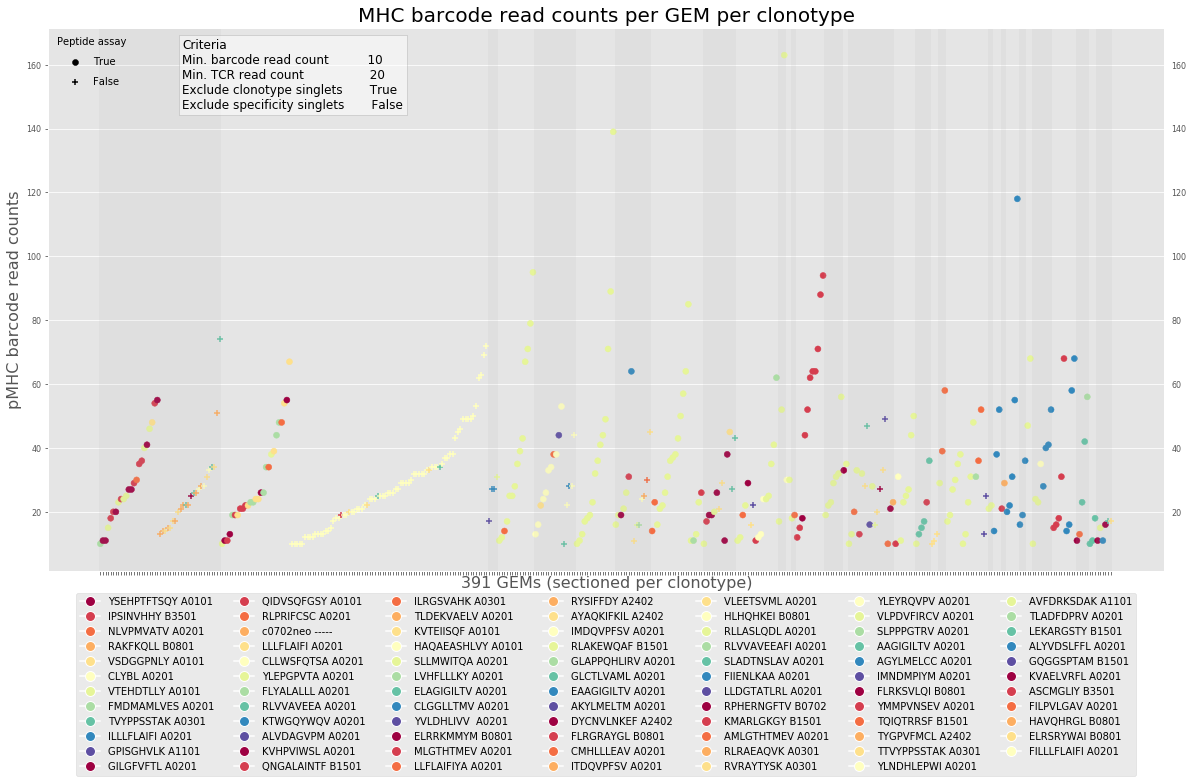

In [48]:
import matplotlib as mpl
mpl.rcParams['axes.grid.axis'] = 'y'#both

project = "read_count_per_clonotype_peptide_assayed/"
version = 1
read_threshold = 1
#gems_threshold = 1
tcr_threshold = 10
exclude_clonotype_singlets = True
exclude_specificity_singlets = True

for read_threshold in [1, 10, 20, 50]:
    for tcr_threshold in [1, 10, 20, 50]:
        for exclude_clonotype_singlets in [True, False]:
            for exclude_specificity_singlets in [True, False]:
                #print(str(read_threshold), str(tcr_threshold), str(exclude_clonotype_singlets), str(exclude_specificity_singlets))
                
                unique_gems = set()

                fig, ax = plt.subplots(figsize=(20, 10))

                xmin, xmax = -0.5, 0

                for i, clonotype in enumerate(credible_df.num_clonotype.unique()):
                    for marker, response in [('o', True), ('+', False)]:
                        sub_df = credible_df[(credible_df.num_clonotype == clonotype) &
                                             (credible_df.read_counts_mhc >= read_threshold) &
                                             (credible_df.peptide_assayed == response) &
                                             (credible_df.umis_tcr >= tcr_threshold)].copy() # & (credible_df.clonotype != 'None') & (credible_df.epitope != '0')
                        if exclude_clonotype_singlets:
                            sub_df.drop(sub_df[~sub_df.duplicated(subset='num_clonotype', keep=False)].index, inplace=True)
                        if exclude_specificity_singlets:
                            sub_df.drop(sub_df[~sub_df.duplicated(subset=['num_clonotype', 'epitope'], keep=False)].index, inplace=True)


                        gems = sub_df.gem.to_list()
                        mhc_read_counts = sub_df.read_counts_mhc.to_list()

                        xmax += len(np.unique(gems))
                        unique_gems.update(sub_df.gem.to_list())

                        epitopes = sub_df.peptide_HLA.to_list()
                        colors = [epitope_to_color[ep] for ep in epitopes]
                        #tcr_umis = credible_df.umis_tcr.to_list()

                        # How to show number of GEMs? Plot a different symbol if only one GEM?
                        #ax.scatter(gems, [-5]*len(gems))
                        scatter = ax.scatter(gems, mhc_read_counts, marker=marker, c=colors) #s=tcr_umis, , edgecolors='face', cmap='viridis_r', norm=plt.Normalize(vmin=0, vmax=1), s=gems, edgecolors='face', alpha=0.3

                    if i % 2 == 0:
                        plt.axvspan(xmin, xmax-0.5, facecolor='0.7', alpha=0.1)

                    xmin = xmax-0.5

                from matplotlib.lines import Line2D

                legend_elements = []
                for epitope_label in all_epitopes:
                    legend_elements += [Line2D([0], [0], marker='o', color='w', label=epitope_label, markerfacecolor=epitope_to_color[epitope_label], markersize=10)]

                legend1 = ax.legend(handles=legend_elements, ncol=7, loc=2, bbox_to_anchor=(0.02, -0.03))
                ax.add_artist(legend1)

                plt.tick_params(labelbottom=False, labelright=True, labelsize=8) #labelbottom=False, 
                plt.xticks(rotation=90, size=2)

                # OBS! DO NOT DELETE
                #for size in [10, 50, 100]:
                #    plt.scatter([], [], c='k', s=size, label=str(size) + " TCR UMIs", marker='o')
                #legend2 = ax.legend(scatterpoints=1, frameon=False, labelspacing=1, title='TCR UMIs', loc='upper left')
                #ax.add_artist(legend2)
                #for marker, response in [('+', "no peptide assay")]: #('o', True), 
                #    plt.scatter([], [], c='k', label=str(response), marker=marker)
                #legend3 = ax.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Label indicator', loc='upper left')
                #ax.add_artist(legend3)

                for marker, response in [('o', True), ('+', False)]:
                    plt.scatter([], [], c='k', label=str(response), marker=marker)
                plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Peptide assay', loc='upper left')

                # Criteria
                textstr = '\n'.join((
                    "Criteria",
                    "Min. barcode read count \t %i".expandtabs() %read_threshold,
                    "Min. TCR read count \t\t    %i".expandtabs() %tcr_threshold,
                    "Exclude clonotype singlets \t %s".expandtabs() %str(exclude_clonotype_singlets),
                    "Exclude specificity singlets \t   %s".expandtabs() %str(exclude_specificity_singlets)))
                props = dict(boxstyle='square', fc='white', ec='grey', alpha=0.5)
                ax.text(0.12, 0.98, textstr,
                        fontsize=12,
                        horizontalalignment='left',
                        verticalalignment='top',
                        clip_on=False,
                        transform=ax.transAxes,
                        bbox=props)

                plt.xlabel("%i GEMs (sectioned per clonotype)" %len(unique_gems), fontsize=16)
                plt.ylabel("pMHC barcode read counts", fontsize=16)
                plt.title("MHC barcode read counts per GEM per clonotype", fontsize=20)
                plt.savefig(FIG_DIR + project + "sortby_%s/"%sortby + "v%i.b%i.t%i.ecs_%s.ess_%s.sortby_%s.pdf" %(version, read_threshold, tcr_threshold, exclude_clonotype_singlets, exclude_specificity_singlets, sortby), bbox_inches='tight')
                plt.savefig(FIG_SUND + project + "sortby_%s/"%sortby + "v%i.b%i.t%i.ecs_%s.ess_%s.sortby_%s.pdf" %(version, read_threshold, tcr_threshold, exclude_clonotype_singlets, exclude_specificity_singlets, sortby), bbox_inches='tight')
                #plt.show()
                plt.cla()   # Clear axis
                plt.clf()   # Clear figure
                plt.close(fig) # Close a figure window

In [80]:
credible_df[credible_df.peptide_HLA.isnull()][['template_id_mhc', 'read_counts_mhc', 'read_counts_lst_mhc', 'template_lst_mhc','template_id_cd8','peptide','HLA', 'epitope', 'epitope_lst']]

template_id_mhc  read_counts_mhc  read_counts_lst_mhc  \
32   A1064B301_bc25mer_21627             14.0           [ 8 14 14]   
289  A1064B301_bc25mer_21627             18.0  [ 1  1  1 15 17 18]   
19   A1064B301_bc25mer_51469             18.0  [ 2  2  2 15 18 18]   
960  A1064B301_bc25mer_21627             21.0           [ 1  2 21]   
240  A1064B301_bc25mer_21627             22.0           [ 1 10 22]   
916  A1064B301_bc25mer_21627             22.0        [ 1  1  2 22]   
602  A1064B301_bc25mer_21627             26.0        [ 1  2  6 26]   
211  A1064B301_bc25mer_21627             30.0              [14 30]   
432  A1064B301_bc25mer_21627             53.0  [ 1  1  2 19 26 53]   
315  A1064B301_bc25mer_21627             25.0           [ 1 24 25]   
24   A1064B301_bc25mer_21627              8.0          [1 1 2 7 8]   
464  A1064B301_bc25mer_21627             10.0        [ 1  2 10 10]   
571  A1064B301_bc25mer_21627             23.0              [ 6 23]   
16   A1064B301_bc25mer_21627             30.0           [ 1 11 30]   
72   A1064B301_bc25mer_21627             25.0              [ 1 25]   
164  A1064B301_bc25mer_21627              9.0              [4 7 9]   
297  A1064B301_bc25mer_21627             44.0           [ 1  2 44]   
383  A1064B301_bc25mer_21627             25.0           [ 1 24 25]   
710  A1064B301_bc25mer_21627             18.0        [ 1  4 13 18]   
714  A1064B301_bc25mer_21627             15.0        [ 1  1 13 15]   

                                      template_lst_mhc  \
32   ['A1064B301_bc25mer_51469' 'A1064B301_bc25mer_...   
289  ['A1064B301_bc25mer_23398' 'A1065B288_bc25mer_...   
19   ['A1064B301_bc25mer_29366' 'A1068B301_bc25mer_...   
960  ['A1064B301_bc25mer_51469' 'A1071B302_bc25mer_...   
240  ['A1067B293_bc25mer_51469' 'A1071B302_bc25mer_...   
916  ['A1064B301_bc25mer_51469' 'A1067B293_bc25mer_...   
602  ['A1064B301_bc25mer_29366' 'A1071B301_bc25mer_...   
211  ['A1071B302_bc25mer_21627' 'A1064B301_bc25mer_...   
432  ['A1064B301_bc25mer_29366' 'A1067B302_bc25mer_...   
315  ['A1064B301_bc25mer_23398' 'A1064B302_bc25mer_...   
24   ['A1064B301_bc25mer_23398' 'A1071B292_bc25mer_...   
464  ['A1071B302_bc25mer_21627' 'A1065B301_bc25mer_...   
571  ['A1064B301_bc25mer_51469' 'A1064B301_bc25mer_...   
16   ['A1064B301_bc25mer_23398' 'A1071B302_bc25mer_...   
72   ['A1071B302_bc25mer_21627' 'A1064B301_bc25mer_...   
164  ['A1071B302_bc25mer_21627' 'A1064B301_bc25mer_...   
297  ['A1071B302_bc25mer_21627' 'A1064B301_bc25mer_...   
383  ['A1064B301_bc25mer_51469' 'A1071B302_bc25mer_...   
710  ['A1066B288_bc25mer_21627' 'A1071B302_bc25mer_...   
714  ['A1064B301_bc25mer_29366' 'A1071B292_bc25mer_...   

             template_id_cd8   peptide  HLA epitope  \
32   A4000B302_bc25mer_51469  c0702neo  NaN     NaN   
289  A4000B302_bc25mer_51469  c0702neo  NaN     NaN   
19   A4000B302_bc25mer_51469  c0702neo  NaN     NaN   
960  A4000B302_bc25mer_51469  c0702neo  NaN     NaN   
240  A4000B302_bc25mer_51469  c0702neo  NaN     NaN   
916  A4000B302_bc25mer_51469  c0702neo  NaN     NaN   
602  A4000B302_bc25mer_51469  c0702neo  NaN     NaN   
211  A4000B302_bc25mer_51469  c0702neo  NaN     NaN   
432  A4000B302_bc25mer_51469  c0702neo  NaN     NaN   
315  A4000B302_bc25mer_51469  c0702neo  NaN     NaN   
24   A4000B302_bc25mer_51469  c0702neo  NaN     NaN   
464  A4000B302_bc25mer_51469  c0702neo  NaN     NaN   
571  A4000B302_bc25mer_51469  c0702neo  NaN     NaN   
16   A4000B302_bc25mer_51469  c0702neo  NaN     NaN   
72   A4000B302_bc25mer_51469  c0702neo  NaN     NaN   
164  A4000B302_bc25mer_51469  c0702neo  NaN     NaN   
297  A4000B302_bc25mer_51469  c0702neo  NaN     NaN   
383  A4000B302_bc25mer_51469  c0702neo  NaN     NaN   
710  A4000B302_bc25mer_51469  c0702neo  NaN     NaN   
714  A4000B302_bc25mer_51469  c0702neo  NaN     NaN   

                                epitope_lst  
32                            [nan nan '0']  
289    [nan 'v15' 'MELPEP-036' '0' nan nan]  
19   [nan 'E14_MELPEP-126' '0

# MHC read count per clonotype (multiple barcodes per GEM)

In [47]:
from ast import literal_eval
literal_eval(sub_df.read_counts_lst_mhc)

ValueError: malformed node or string: 1054    [1 1 3 4]
Name: read_counts_lst_mhc, dtype: object

In [ ]:
from ast import literal_eval
import matplotlib as mpl
mpl.rcParams['axes.grid.axis'] = 'y'#both

project = "read_count_per_clonotype_multiple_barcodes/"
version = 1
read_threshold = 1
gems_threshold = 1
#clonotype_threshold = 2

all_clonotypes = credible_df.clonotype.unique()
num_clonotypes = len(all_clonotypes)

fig, ax = plt.subplots(figsize=(20, 10))

xmin, xmax = -0.5, 0

for i, clonotype in enumerate(credible_df.num_clonotype.unique()):
    for marker, response in [('o', True), ('+', False)]:
        sub_df = credible_df[(credible_df.num_clonotype == clonotype) &
                             (credible_df.read_counts_mhc >= read_threshold) &
                             (credible_df.peptide_assayed == response)].copy() # & (credible_df.clonotype != 'None') & (credible_df.epitope != '0')
        sub_df.drop(sub_df[~sub_df.duplicated(subset='num_clonotype', keep=False)].index, inplace=True)
        
        gems = sub_df.gem.to_list()
        mhc_read_counts = sub_df.read_counts_mhc.to_list()

        xmax += len(np.unique(gems))

        epitopes = sub_df.epitope.to_list()
        colors = [epitope_to_color[ep] for ep in epitopes]

        # How to show number of GEMs? Plot a different symbol if only one GEM?
        #ax.scatter(gems, [-5]*len(gems))
        scatter = ax.scatter(gems, mhc_read_counts, marker=marker, c=colors) #, edgecolors='face', cmap='viridis_r', norm=plt.Normalize(vmin=0, vmax=1), s=gems, edgecolors='face', alpha=0.3

    if i % 2 == 0:
        plt.axvspan(xmin, xmax-0.5, facecolor='0.7', alpha=0.1)
    #print(i)    
    #print(clonotype)
    #print(len(gems))
    #print(xmin, xmax)

    xmin = xmax-0.5
            
from matplotlib.lines import Line2D

legend_elements = []
for epitope_label in all_epitopes:
    legend_elements += [Line2D([0], [0], marker='o', color='w', label=epitope_label, markerfacecolor=epitope_to_color[epitope_label], markersize=10)]

legend1 = ax.legend(handles=legend_elements, ncol=8, loc=2, bbox_to_anchor=(0.02, -0.03))
ax.add_artist(legend1)

plt.tick_params(labelbottom=False, labelright=True, labelsize=8) #labelbottom=False, 
plt.xticks(rotation=90, size=2)

for marker, response in [('o', True), ('+', False)]:
    plt.scatter([], [], c='k', label=str(response), marker=marker)
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Peptide assayed', loc='upper right')

plt.xlabel("GEMs per clonotype", fontsize=16)
plt.ylabel("pMHC barcode read counts", fontsize=16)
plt.title("MHC barcode read counts per GEM per clonotype (min. read count per GEM: %i, min. GEM count: %i)"%(read_threshold, gems_threshold), fontsize=20)
#plt.savefig(FIG_DIR + project + "v%i.min_read_count_%i.min_gem_count_%i.pdf" %(version, read_threshold, gems_threshold), bbox_inches='tight')
plt.show()

# TCR read count per clonotype

In [39]:
sortby = 'umis_tcr'
credible_df.sort_values(by=['num_clonotype', sortby], inplace=True)

In [42]:
import matplotlib as mpl
mpl.rcParams['axes.grid.axis'] = 'y'#both

project = "tcr_read_count_per_clonotype_detected_response/"
version = 1
read_threshold = 1
#gems_threshold = 1
tcr_threshold = 10
exclude_clonotype_singlets = True
exclude_specificity_singlets = True

for read_threshold in [1, 10, 20, 50]:
    for tcr_threshold in [1, 10, 20, 50]:
        for exclude_clonotype_singlets in [True, False]:
            for exclude_specificity_singlets in [True, False]:
                #print(str(read_threshold), str(tcr_threshold), str(exclude_clonotype_singlets), str(exclude_specificity_singlets))

                fig, ax = plt.subplots(figsize=(20, 10))

                xmin, xmax = -0.5, 0

                for i, clonotype in enumerate(credible_df.num_clonotype.unique()):
                    for marker, response in [('o', True), ('+', False)]:
                        sub_df = credible_df[(credible_df.num_clonotype == clonotype) &
                                             (credible_df.read_counts_mhc >= read_threshold) &
                                             (credible_df.umis_tcr >= tcr_threshold) & 
                                             (credible_df.detected_response == response)].copy()
                        if exclude_clonotype_singlets:
                            sub_df.drop(sub_df[~sub_df.duplicated(subset='num_clonotype', keep=False)].index, inplace=True)
                        if exclude_specificity_singlets:
                            sub_df.drop(sub_df[~sub_df.duplicated(subset=['num_clonotype', 'epitope'], keep=False)].index, inplace=True)

                        gems = sub_df.gem.to_list()
                        tcr_read_counts = sub_df.umis_tcr.values

                        xmax += len(np.unique(gems))

                        epitopes = sub_df.peptide_HLA.to_list()
                        colors = [epitope_to_color[ep] for ep in epitopes]

                        # How to show number of GEMs? Plot a different symbol if only one GEM?
                        #ax.scatter(gems, [-5]*len(gems))
                        scatter = ax.scatter(gems, tcr_read_counts, marker=marker, c=colors) #, edgecolors='face', cmap='viridis_r', norm=plt.Normalize(vmin=0, vmax=1), s=gems, edgecolors='face', alpha=0.3

                    if i % 2 == 0:
                        plt.axvspan(xmin, xmax-0.5, facecolor='0.7', alpha=0.1)

                    xmin = xmax-0.5

                from matplotlib.lines import Line2D

                legend_elements = []
                for epitope_label in all_epitopes:
                    legend_elements += [Line2D([0], [0], marker='o', color='w', label=epitope_label, markerfacecolor=epitope_to_color[epitope_label], markersize=10)]

                legend1 = ax.legend(handles=legend_elements, ncol=8, loc=2, bbox_to_anchor=(0.02, -0.03))
                ax.add_artist(legend1)

                plt.tick_params(labelbottom=False, labelright=True, labelsize=8) #labelbottom=False, 
                plt.xticks(rotation=90, size=2)

                for marker, response in [('o', True), ('+', False)]:
                    plt.scatter([], [], c='k', label=str(response), marker=marker)
                plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Detected response', loc='upper right')

                # Criteria
                textstr = '\n'.join((
                    "Criteria",
                    "Min. barcode read count \t %i".expandtabs() %read_threshold,
                    "Min. TCR read count \t\t    %i".expandtabs() %tcr_threshold,
                    "Exclude clonotype singlets \t %s".expandtabs() %str(exclude_clonotype_singlets),
                    "Exclude specificity singlets \t   %s".expandtabs() %str(exclude_specificity_singlets)))
                props = dict(boxstyle='square', fc='white', ec='grey', alpha=0.5)
                ax.text(0.05, 0.95, textstr,
                        fontsize=12,
                        horizontalalignment='left',
                        verticalalignment='top',
                        clip_on=False,
                        transform=ax.transAxes,
                        bbox=props)
                
                plt.xlabel("GEMs per clonotype", fontsize=16)
                plt.ylabel("TCR barcode read counts", fontsize=16)
                plt.title("TCR barcode read counts per GEM per clonotype", fontsize=20)
                plt.savefig(FIG_DIR + project + "v%i.b%i.t%i.ecs_%s.ess_%s.sortby_%s.pdf" %(version, read_threshold, tcr_threshold, exclude_clonotype_singlets, exclude_specificity_singlets, sortby), bbox_inches='tight')
                plt.savefig(FIG_SUND + project + "v%i.b%i.t%i.ecs_%s.ess_%s.sortby_%s.pdf" %(version, read_threshold, tcr_threshold, exclude_clonotype_singlets, exclude_specificity_singlets, sortby), bbox_inches='tight')
                #plt.show()
                plt.cla()   # Clear axis
                plt.clf()   # Clear figure
                plt.close(fig) # Close a figure window

# Binding concordance distribution

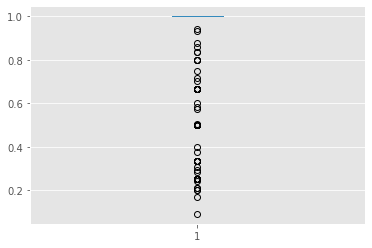

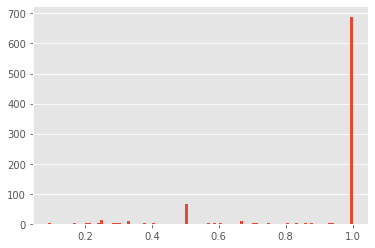

In [90]:
plt.boxplot(credible_df.groupby('clonotype').binding_concordance.max().values)
plt.show()
plt.hist(credible_df.groupby('clonotype').binding_concordance.max().values, bins=100)
plt.show()

In [91]:
credible_df.columns.values

array(['gem', 'clonotype', 'cdr3_TRA', 'cdr3_nt_TRA', 'cdr3_TRB',
       'cdr3_nt_TRB', 'umis_TRA', 'umis_diff_TRA', 'single_TRA',
       'umis_lst_TRA', 'cdr3_lst_TRA', 'umis_TRB', 'umis_diff_TRB',
       'single_TRB', 'umis_lst_TRB', 'cdr3_lst_TRB', 'match_mhc',
       'credible_alignment_mhc', 'match_cd8', 'credible_alignment_cd8',
       'template_id_mhc', 'read_counts_mhc', 'read_count_diff_mhc',
       'single_barcode_mhc', 'read_counts_lst_mhc', 'template_lst_mhc',
       'template_id_cd8', 'read_counts_cd8', 'read_count_diff_cd8',
       'single_barcode_cd8', 'read_counts_lst_cd8', 'template_lst_cd8',
       'detected_response', 'peptide', 'HLA', 'epitope', 'epitope_lst',
       '0', '134 (I-A22)neo26', '14 (A14)neo37', '147 (I-E15)neo26',
       '19 (A19)neo37', '20 (A20)neo37', '256 (II- E2)neo26',
       '29 (C5)neo37', '30 (C6)neo37', '31 (C7)neo37', '32 (C8)neo37',
       '40 (C16)neo37', 'A11_17_1_11', 'C2_MELPEP-014', 'CLYBL',
       'E14_MELPEP-126', 'E24_MELPEP-139', '

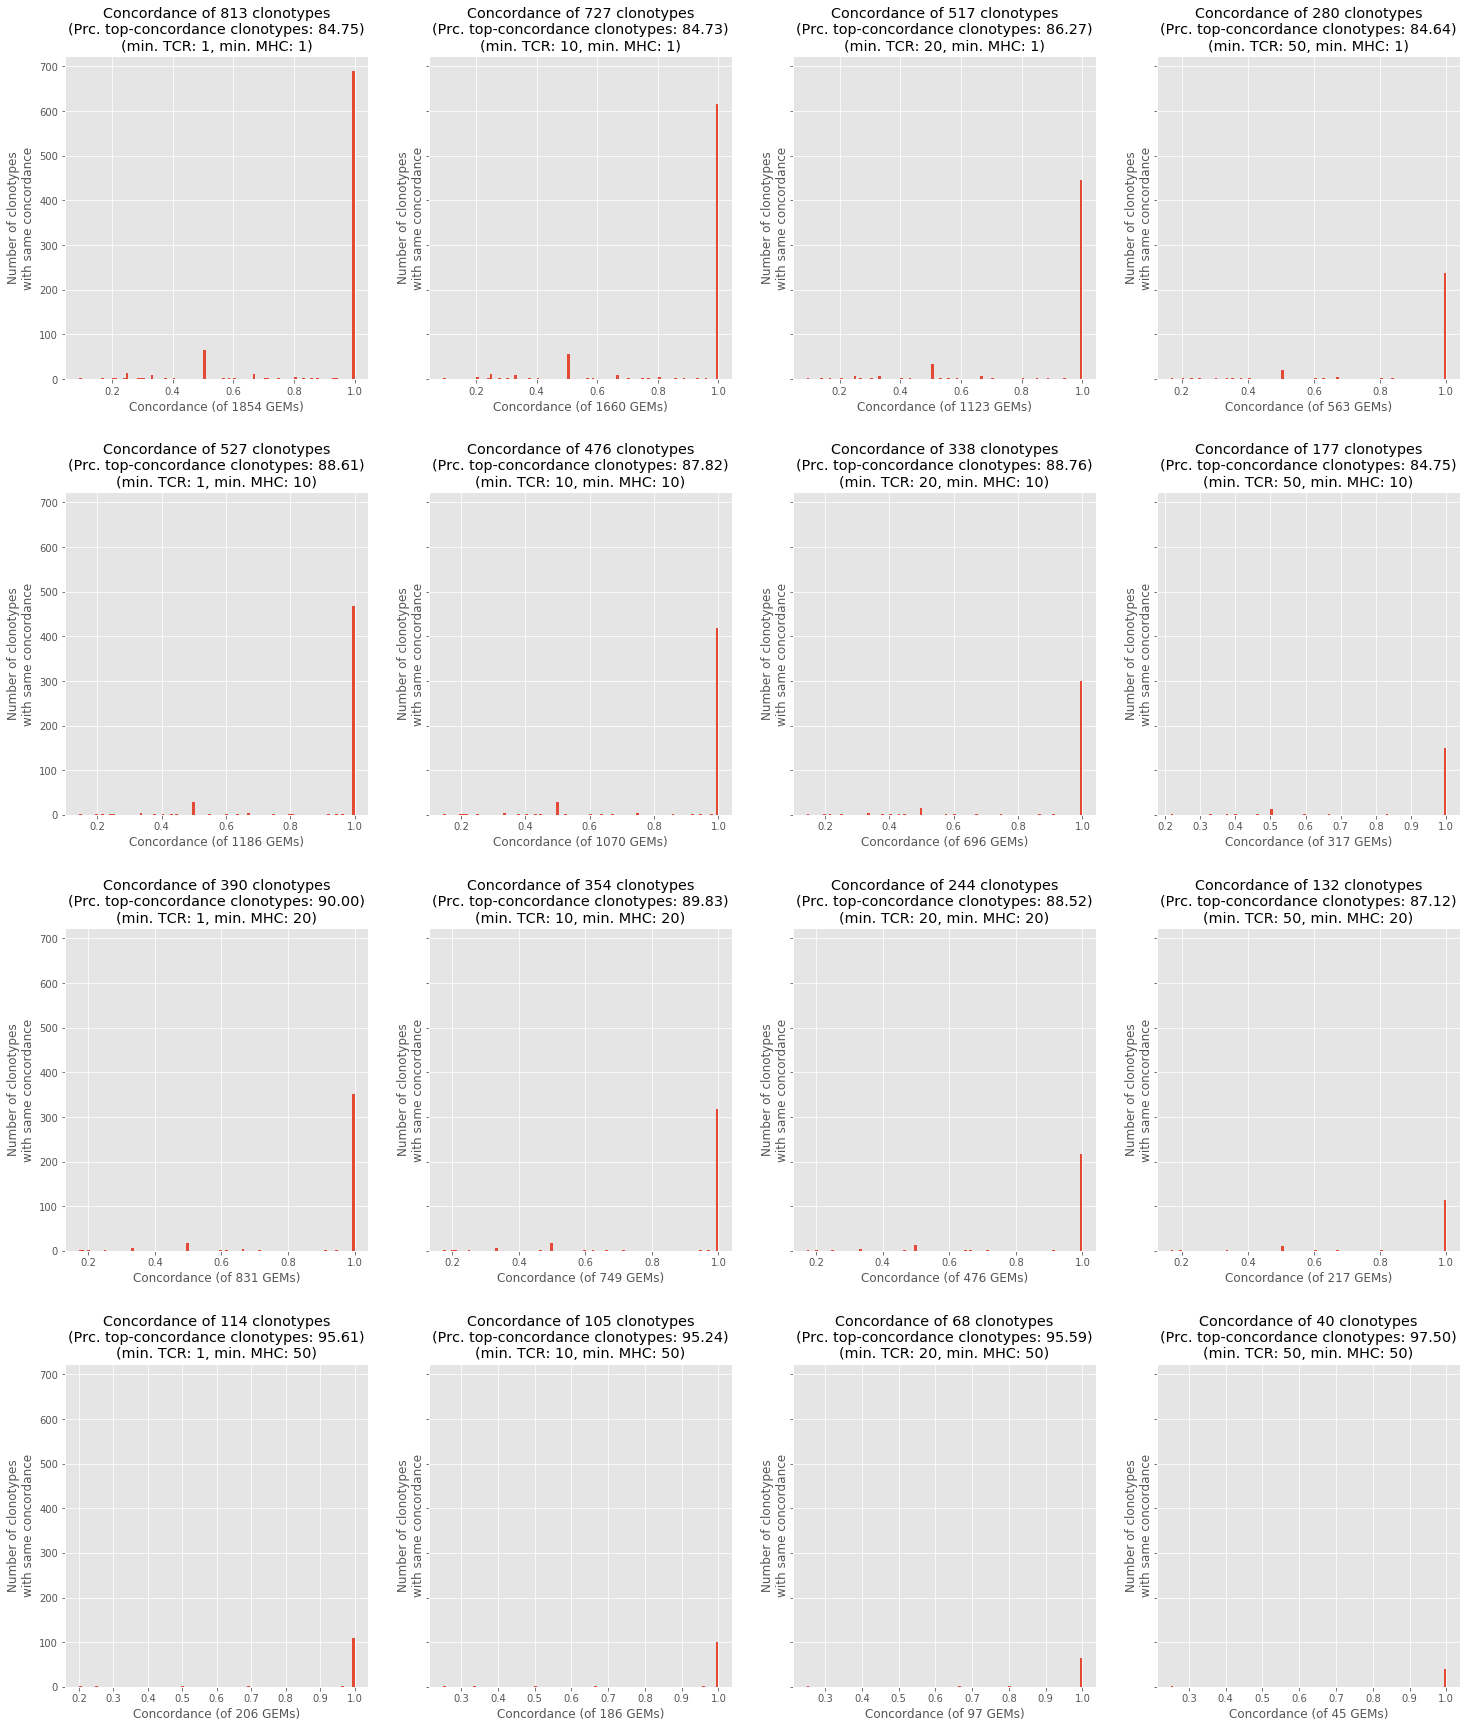

In [45]:
mhc_read_threshold = 1
tcr_read_threshold = 10

#fig = plt.figure(figsize=(25,30))
fig, ax = plt.subplots(4, 4, sharey=True, figsize=(25,30))
fig.subplots_adjust(hspace=0.35)

for i, mhc_read_threshold in enumerate([1, 10, 20, 50]):
    for j, tcr_read_threshold in enumerate([1, 10, 20, 50]):
        t_df = credible_df[(credible_df.read_counts_mhc >= mhc_read_threshold) & (credible_df.umis_tcr >= tcr_read_threshold)]
        a = t_df.groupby(['clonotype','epitope']).gem.count().to_frame()
        a.rename(columns={'gem': 'gems_per_specificity'}, inplace=True)

        b = t_df.groupby(['clonotype']).gem.count().to_frame()
        b.rename(columns={'gem': 'gems_per_clonotype'}, inplace=True)

        c = pd.merge(a,b, on='clonotype')
        c['binding_concordance'] = c.gems_per_specificity / c.gems_per_clonotype

        #print(c.groupby('clonotype').binding_concordance.max().mean())
        #plt.boxplot(c.groupby('clonotype').binding_concordance.max().values)
        #plt.show()

        #plt.subplot(4, 4, i*4+j)
        ax[i,j].hist(c.groupby('clonotype').binding_concordance.max().values, bins=100)
        ax[i,j].set_ylabel("Number of clonotypes\nwith same concordance")
        ax[i,j].set_xlabel("Concordance (of %i GEMs)" %b.gems_per_clonotype.sum())
        ax[i,j].set_title("Concordance of %i clonotypes\n(Prc. top-concordance clonotypes: %3.2f)\n(min. TCR: %i, min. MHC: %i)" %(b.size, (c.groupby('clonotype').binding_concordance.max() == 1).sum()/b.size*100, tcr_read_threshold, mhc_read_threshold))
        #plt.subplots_adjust(hspace=0.4)
plt.show()

In [44]:
(c.groupby('clonotype').binding_concordance.max() == 1).sum()/b.size

0.975

In [40]:
(c.groupby('clonotype').binding_concordance.max() == 1)

clonotype
clonotype1       False
clonotype115      True
clonotype1197     True
clonotype121      True
clonotype1282     True
clonotype136      True
clonotype138      True
clonotype1384     True
clonotype1397     True
clonotype1441     True
clonotype1471     True
clonotype149      True
clonotype153      True
clonotype2        True
clonotype2066     True
clonotype207      True
clonotype2200     True
clonotype2217     True
clonotype2318     True
clonotype2327     True
clonotype2339     True
clonotype24       True
clonotype2407     True
clonotype2429     True
clonotype2489     True
clonotype2660     True
clonotype2688     True
clonotype280      True
clonotype31       True
clonotype316      True
clonotype32       True
clonotype5        True
clonotype51       True
clonotype54       True
clonotype628      True
clonotype677      True
clonotype7        True
clonotype76       True
clonotype775      True
clonotype918      True
Name: binding_concordance, dtype: bool

In [37]:
c.groupby('clonotype').binding_concordance.max()[(c.groupby('clonotype').binding_concordance.max() == 1).values]

clonotype
clonotype115     1.0
clonotype1197    1.0
clonotype121     1.0
clonotype1282    1.0
clonotype136     1.0
clonotype138     1.0
clonotype1384    1.0
clonotype1397    1.0
clonotype1441    1.0
clonotype1471    1.0
clonotype149     1.0
clonotype153     1.0
clonotype2       1.0
clonotype2066    1.0
clonotype207     1.0
clonotype2200    1.0
clonotype2217    1.0
clonotype2318    1.0
clonotype2327    1.0
clonotype2339    1.0
clonotype24      1.0
clonotype2407    1.0
clonotype2429    1.0
clonotype2489    1.0
clonotype2660    1.0
clonotype2688    1.0
clonotype280     1.0
clonotype31      1.0
clonotype316     1.0
clonotype32      1.0
clonotype5       1.0
clonotype51      1.0
clonotype54      1.0
clonotype628     1.0
clonotype677     1.0
clonotype7       1.0
clonotype76      1.0
clonotype775     1.0
clonotype918     1.0
Name: binding_concordance, dtype: float64

In [39]:
a.groupby(['clonotype']).gems_per_specificity.unique()

clonotype
clonotype1       [1]
clonotype115     [2]
clonotype1197    [1]
clonotype121     [1]
clonotype1282    [1]
clonotype136     [1]
clonotype138     [1]
clonotype1384    [1]
clonotype1397    [1]
clonotype1441    [1]
clonotype1471    [1]
clonotype149     [2]
clonotype153     [1]
clonotype2       [1]
clonotype2066    [1]
clonotype207     [1]
clonotype2200    [1]
clonotype2217    [1]
clonotype2318    [1]
clonotype2327    [1]
clonotype2339    [1]
clonotype24      [1]
clonotype2407    [1]
clonotype2429    [1]
clonotype2489    [1]
clonotype2660    [1]
clonotype2688    [1]
clonotype280     [1]
clonotype31      [1]
clonotype316     [1]
clonotype32      [1]
clonotype5       [1]
clonotype51      [1]
clonotype54      [1]
clonotype628     [1]
clonotype677     [1]
clonotype7       [1]
clonotype76      [1]
clonotype775     [1]
clonotype918     [1]
Name: gems_per_specificity, dtype: object

In [ ]:
gems = sub_df.groupby(['clonotype']).gems_per_specificity.mean().values

In [97]:
b.shape

(727, 1)

In [29]:
credible_df = pd.merge(tmp_df, gems_per_specificity_df, on=['clonotype', 'epitope'], how='left').merge(gems_per_clonotype_df, on='clonotype', how='left')

In [30]:
credible_df['binding_concordance'] = credible_df.gems_per_specificity / credible_df.gems_per_clonotype

In [99]:
credible_df.groupby(['clonotype','epitope']).gem.count().to_frame().reset_index()

clonotype           epitope  gem
0       clonotype1  134 (I-A22)neo26    5
1       clonotype1     20 (A20)neo37    1
2       clonotype1       A11_17_1_11    2
3       clonotype1             CLYBL    7
4       clonotype1    E24_MELPEP-139    1
5       clonotype1               v10    1
6       clonotype1               v11    1
7       clonotype1               v13    1
8       clonotype1               v15    8
9       clonotype1               v17    1
10      clonotype1               v19    5
11      clonotype1               v22    1
12      clonotype1               v23    4
13      clonotype1                v8    1
14      clonotype1                v9    5
15     clonotype10               v15   23
16    clonotype100        MELPEP-067    1
17    clonotype100                v9    1
18   clonotype1013        K7_17_1_67    2
19   clonotype1014               v15    2
20   clonotype1053                v9    1
21    clonotype106        MELPEP-036    1
22    clonotype106        MELPEP-044    1
23   clonotype1067        MELPEP-044    2
24   clonotype1068        MELPEP-013    2
25   clonotype1088               v10    4
26   clonotype1097               v13    1
27   clonotype1097               v15    1
28   clonotype1101               v15    1
29   clonotype1106               v15    1
..             ...               ...  ...
548    clonotype80               v17    1
549   clonotype819    E24_MELPEP-139    1
550   clonotype835               v16    2
551   clonotype847                v9    1
552    clonotype85             CLYBL    2
553    clonotype85               v10    2
554    clonotype85               v13    6
555   clonotype850       A11_17_1_11    1
556   clonotype861               v19    2
557    clonotype87             CLYBL    2
558    clonotype88               v16    1
559    clonotype88               v24    1
560     clonotype9       A11_17_1_11    1
561     clonotype9               v13    1
562     clonotype9               v15    1
563     clonotype9               v19    1
564     clonotype9                v4    1
565     clonotype9                v9    1
566   clonotype918               v15    1
567    clonotype92               v15    2
568   clonotype920    E24_MELPEP-139    1
569   clonotype925       A11_17_1_11    4
570   clonotype927  134 (I-A22)neo26    2
571   clonotype931               v15    1
572   clonotype958               v17    1
573   clonotype967        MELPEP-041    1
574    clonotype97               v23    1
575   clonotype976                v9    1
576    clonotype98               v19    1
577   clonotype985        MELPEP-056    1

[578 rows x 3 columns]

In [100]:
credible_df.groupby(['clonotype']).gem.count().to_frame().reset_index()

clonotype  gem
0       clonotype1   52
1      clonotype10   23
2     clonotype100    2
3    clonotype1013    2
4    clonotype1014    2
5    clonotype1053    1
6     clonotype106    2
7    clonotype1067    2
8    clonotype1068    2
9    clonotype1088    4
10   clonotype1097    2
11   clonotype1101    1
12   clonotype1106    1
13    clonotype111    3
14   clonotype1111    4
15   clonotype1125    1
16    clonotype113    2
17   clonotype1136    2
18    clonotype114    1
19    clonotype115    2
20   clonotype1153    2
21    clonotype116    2
22   clonotype1170    1
23    clonotype118    1
24   clonotype1183    4
25   clonotype1189    2
26    clonotype119    2
27   clonotype1190    1
28   clonotype1192    1
29   clonotype1197    1
..             ...  ...
392    clonotype76    1
393    clonotype77    3
394   clonotype774    1
395   clonotype776    4
396   clonotype788    4
397    clonotype79    2
398     clonotype8   14
399    clonotype80    2
400   clonotype819    1
401   clonotype835    2
402   clonotype847    1
403    clonotype85   10
404   clonotype850    1
405   clonotype861    2
406    clonotype87    2
407    clonotype88    2
408     clonotype9    6
409   clonotype918    1
410    clonotype92    2
411   clonotype920    1
412   clonotype925    4
413   clonotype927    2
414   clonotype931    1
415   clonotype951    9
416   clonotype958    1
417   clonotype967    1
418    clonotype97    2
419   clonotype976    1
420    clonotype98    1
421   clonotype985    1

[422 rows x 2 columns]

In [101]:
gems_per_specificity_df = credible_df.groupby(['clonotype','epitope']).gem.count().to_frame().reset_index()
gems_per_specificity_df.rename(columns={'gem': 'gems_per_specificity'}, inplace=True)

In [102]:
gems_per_clonotype_df = credible_df.groupby(['clonotype']).gem.count().to_frame().reset_index()
gems_per_clonotype_df.rename(columns={'gem': 'gems_per_clonotype'}, inplace=True)

In [103]:
binding_concordance_df = pd.merge(gems_per_specificity_df, gems_per_clonotype_df, on=['clonotype'], how='left')

In [106]:
binding_concordance_df['binding_concordance'] = binding_concordance_df.gems_per_specificity / binding_concordance_df.gems_per_clonotype

In [107]:
binding_concordance_df

clonotype           epitope  gems_per_specificity  \
0       clonotype1  134 (I-A22)neo26                     5   
1       clonotype1     20 (A20)neo37                     1   
2       clonotype1       A11_17_1_11                     2   
3       clonotype1             CLYBL                     7   
4       clonotype1    E24_MELPEP-139                     1   
5       clonotype1               v10                     1   
6       clonotype1               v11                     1   
7       clonotype1               v13                     1   
8       clonotype1               v15                     8   
9       clonotype1               v17                     1   
10      clonotype1               v19                     5   
11      clonotype1               v22                     1   
12      clonotype1               v23                     4   
13      clonotype1                v8                     1   
14      clonotype1                v9                     5   
15     clonotype10               v15                    23   
16    clonotype100        MELPEP-067                     1   
17    clonotype100                v9                     1   
18   clonotype1013        K7_17_1_67                     2   
19   clonotype1014               v15                     2   
20   clonotype1053                v9                     1   
21    clonotype106        MELPEP-036                     1   
22    clonotype106        MELPEP-044                     1   
23   clonotype1067        MELPEP-044                     2   
24   clonotype1068        MELPEP-013                     2   
25   clonotype1088               v10                     4   
26   clonotype1097               v13                     1   
27   clonotype1097               v15                     1   
28   clonotype1101               v15                     1   
29   clonotype1106               v15                     1   
..             ...               ...                   ...   
548    clonotype80               v17                     1   
549   clonotype819    E24_MELPEP-139                     1   
550   clonotype835               v16                     2   
551   clonotype847                v9                     1   
552    clonotype85             CLYBL                     2   
553    clonotype85               v10                     2   
554    clonotype85               v13                     6   
555   clonotype850       A11_17_1_11                     1   
556   clonotype861               v19                     2   
557    clonotype87             CLYBL                     2   
558    clonotype88               v16                     1   
559    clonotype88               v24                     1   
560     clonotype9       A11_17_1_11                     1   
561     clonotype9               v13                     1   
562     clonotype9               v15                     1   
563     clonotype9               v19                     1   
564     clonotype9                v4                     1   
565     clonotype9                v9                     1   
566   clonotype918               v15                     1   
567    clonotype92               v15                     2   
568   clonotype920    E24_MELPEP-139                     1   
569   clonotype925       A11_17_1_11                     4   
570   clonotype927  134 (I-A22)neo26                     2   
571   clonotype931               v15                     1   
572   clonotype958               v17                     1   
573   clonotype967        MELPEP-041                     1   
574    clonotype97               v23                     1   
575   clonotype976                v9                     1   
576    clonotype98               v19                     1   
577   clonotype985        MELPEP-056                     1   

     gems_per_clonotype  binding_concordance  
0                    52             0.096154  
1                    52             0.019231  
2                    52

In [49]:
credible_df['binding_concordance'] = credible_df.gems_per_specificity / credible_df.gems_per_clonotype

{'whiskers': [<matplotlib.lines.Line2D at 0x1212ab2b0>,
 'caps': [<matplotlib.lines.Line2D at 0x1208aea20>,
 'boxes': [<matplotlib.lines.Line2D at 0x1212ab588>],
 'medians': [<matplotlib.lines.Line2D at 0x1208ae9e8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1208ae3c8>],
 'means': []}

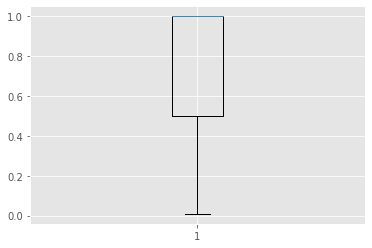

In [98]:
plt.boxplot(credible_df[credible_df.read_counts_mhc >= 20].binding_concordance.dropna().values)

In [94]:
credible_df.binding_concordance.describe()

count    1205.000000
mean        0.729395
std         0.362953
min         0.008696
25%         0.495652
50%         1.000000
75%         1.000000
max         1.000000
Name: binding_concordance, dtype: float64

In [78]:
credible_df.sort_values(by=['num_clonotype', 'gem'])[credible_df.gem == 'AAAGATGAGGTGACCA-1'].clonotype

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


6    clonotype528
5    clonotype528
4    clonotype528
3    clonotype528
Name: clonotype, dtype: object

In [71]:
credible_df.groupby(['gem']).size()

gem
AAACCTGAGTTCGATC-1    1
AAACGGGCAGGTCTCG-1    1
AAACGGGTCCAGAGGA-1    1
AAAGATGAGGTGACCA-1    4
AAAGATGCACCGAATT-1    1
AAAGATGTCTCAACTT-1    2
AAAGCAAGTATTAGCC-1    1
AAATGCCAGACGCACA-1    1
AAATGCCTCGTTTGCC-1    1
AACACGTTCTTGAGAC-1    1
AACCATGCACCAGGTC-1    1
AACCATGGTTGCGTTA-1    1
AACCATGTCGGTCCGA-1    2
AACCGCGCAGGAATGC-1    1
AACCGCGTCAGCTTAG-1    1
AACGTTGCAGACGCTC-1    1
AACTCAGGTCTCACCT-1    2
AACTCAGTCTTGAGAC-1    1
AACTCTTCACCAGCAC-1    4
AACTGGTAGCCCGAAA-1    1
AACTGGTCATTTCAGG-1    1
AACTTTCTCATTGCGA-1    1
AAGCCGCAGGCTAGAC-1    1
AAGCCGCAGTGATCGG-1    1
AAGCCGCGTTGAGTTC-1    4
AAGCCGCTCCCTAACC-1    1
AAGGAGCAGCTAAGAT-1    1
AAGGAGCCAGTGACAG-1    1
AAGGAGCGTTTGTGTG-1    1
AAGGCAGTCTTTACGT-1    1
                     ..
TTCTTAGCAATGAAAC-1    2
TTGAACGCAAGTCTAC-1    1
TTGAACGCATAAAGGT-1    1
TTGAACGGTAAGGGAA-1    2
TTGCCGTAGGAGTTTA-1    6
TTGCCGTTCAACACGT-1    2
TTGCCGTTCGGAAATA-1    1
TTGCCGTTCTGGTGTA-1    1
TTGCGTCAGCTATGCT-1    1
TTGCGTCAGTGACATA-1    1
TTGCGTCAGTGT

In [61]:
print(len(credible_df.umis_TRA.values))
print(len(credible_df.umis_TRA.values + credible_df.umis_TRB.values))

1237
1237


In [59]:
credible_df.umis_TRA.values + credible_df.umis_TRB.values

array([32., 33., 36., ..., 42., 31., 32.])

In [43]:
d = ax.collections[0]

d.set_offset_position('data')

print(d.get_offsets())

[[0.0 22.0]
 [1.0 34.0]
 [2.0 1.0]
 [3.0 24.0]
 [4.0 25.0]
 [5.0 28.0]
 [6.0 30.0]
 [7.0 21.0]
 [8.0 1.0]
 [9.0 34.0]
 [10.0 1.0]
 [11.0 26.0]
 [12.0 1.0]
 [13.0 1.0]
 [14.0 1.0]
 [15.0 24.0]
 [16.0 46.0]
 [17.0 1.0]
 [18.0 1.0]
 [19.0 14.0]
 [20.0 53.0]
 [21.0 20.0]
 [22.0 55.0]
 [23.0 54.0]
 [24.0 27.0]
 [25.0 1.0]
 [26.0 1.0]
 [27.0 37.0]
 [28.0 1.0]
 [29.0 1.0]
 [30.0 22.0]
 [31.0 30.0]
 [32.0 18.0]
 [33.0 26.0]
 [34.0 25.0]
 [35.0 74.0]
 [36.0 27.0]
 [37.0 1.0]
 [38.0 31.0]
 [39.0 1.0]
 [40.0 35.0]
 [41.0 1.0]
 [42.0 33.0]
 [43.0 1.0]
 [44.0 14.0]
 [45.0 27.0]
 [46.0 20.0]
 [47.0 1.0]
 [48.0 2.0]
 [49.0 48.0]
 [50.0 1.0]
 [51.0 22.0]]


In [46]:
pd.DataFrame(d.get_offsets(), columns=['x','y']).x

0      0.0
1      1.0
2      2.0
3      3.0
4      4.0
5      5.0
6      6.0
7      7.0
8      8.0
9      9.0
10    10.0
11    11.0
12    12.0
13    13.0
14    14.0
15    15.0
16    16.0
17    17.0
18    18.0
19    19.0
20    20.0
21    21.0
22    22.0
23    23.0
24    24.0
25    25.0
26    26.0
27    27.0
28    28.0
29    29.0
30    30.0
31    31.0
32    32.0
33    33.0
34    34.0
35    35.0
36    36.0
37    37.0
38    38.0
39    39.0
40    40.0
41    41.0
42    42.0
43    43.0
44    44.0
45    45.0
46    46.0
47    47.0
48    48.0
49    49.0
50    50.0
51    51.0
Name: x, dtype: float64

In [35]:
ax.get_xlim()

(-28.14113173814028, 587.6456398389041)

In [37]:
scatter

# Testing

In [50]:
df = credible_df[(credible_df.epitope == 'v6') & (credible_df.read_counts_mhc >= read_threshold) & (credible_df.clonotype != 'None')]

In [51]:
df.loc[:,['gem', 'clonotype', 'epitope','gems_per_clonotype','gems_per_specificity', 'binding_concordance']]

gem      clonotype epitope  gems_per_clonotype  \
3656  CACACCTAGAAAGTGG-1    clonotype56      v6                   1   
3737  CGCTTCACAATAACGA-1    clonotype67      v6                   1   
2839  CGTTGGGCATTTGCCC-1  clonotype1529      v6                   1   
3283  TCGTAGAGTGTAATGA-1  clonotype2449      v6                   2   
3282  TCGTAGAGTGTAATGA-1  clonotype2449      v6                   2   
3338  TTATGCTAGGCCATAG-1  clonotype2647      v6                   1   

      gems_per_specificity  binding_concordance  
3656                   1.0                  1.0  
3737                   1.0                  1.0  
2839                   1.0                  1.0  
3283                   2.0                  1.0  
3282                   2.0                  1.0  
3338                   1.0                  1.0

In [18]:
df.clonotype.str.split('clonotype').str[1].unique()

array(['1', '111', '1192', '1476', '1533', '156', '1591', '1688', '1705',
       '195', '1969', '2', '2013', '2069', '2337', '27', '2710', '357',
       '389', '4', '402', '453', '5', '658', '745', '85', '87'],
      dtype=object)

In [19]:
df.clonotype.unique()

array(['clonotype1', 'clonotype111', 'clonotype1192', 'clonotype1476',
       'clonotype1533', 'clonotype156', 'clonotype1591', 'clonotype1688',
       'clonotype1705', 'clonotype195', 'clonotype1969', 'clonotype2',
       'clonotype2013', 'clonotype2069', 'clonotype2337', 'clonotype27',
       'clonotype2710', 'clonotype357', 'clonotype389', 'clonotype4',
       'clonotype402', 'clonotype453', 'clonotype5', 'clonotype658',
       'clonotype745', 'clonotype85', 'clonotype87'], dtype=object)

In [28]:
df.groupby(['clonotype']).binding_concordance.mean()

clonotype
clonotype1       0.122807
clonotype111     0.333333
clonotype1192    1.000000
clonotype1476    1.000000
clonotype1533    1.000000
clonotype156     1.000000
clonotype1591    1.000000
clonotype1688    1.000000
clonotype1705    1.000000
clonotype195     0.500000
clonotype1969    1.000000
clonotype2       0.486726
clonotype2013    1.000000
clonotype2069    1.000000
clonotype2337    1.000000
clonotype27      0.750000
clonotype2710    1.000000
clonotype357     0.500000
clonotype389     0.333333
clonotype4       0.050847
clonotype402     1.000000
clonotype453     1.000000
clonotype5       0.071429
clonotype658     1.000000
clonotype745     1.000000
clonotype85      0.200000
clonotype87      1.000000
Name: binding_concordance, dtype: float64

In [37]:
df.groupby(['clonotype']).gem.count()

clonotype
clonotype1       1
clonotype1088    1
clonotype123     1
clonotype1647    1
clonotype2       7
clonotype2037    1
clonotype218     1
clonotype226     1
clonotype233     1
clonotype24      1
clonotype2466    1
clonotype258     1
clonotype2666    1
clonotype269     1
clonotype3       1
clonotype328     1
clonotype59      1
clonotype63      1
clonotype75      1
clonotype85      1
Name: gem, dtype: int64

In [39]:
df.groupby(['clonotype','epitope']).gem.count()

clonotype      epitope
clonotype1     v10        1
clonotype1088  v10        1
clonotype123   v10        1
clonotype1647  v10        1
clonotype2     v10        7
clonotype2037  v10        1
clonotype218   v10        1
clonotype226   v10        1
clonotype233   v10        1
clonotype24    v10        1
clonotype2466  v10        1
clonotype258   v10        1
clonotype2666  v10        1
clonotype269   v10        1
clonotype3     v10        1
clonotype328   v10        1
clonotype59    v10        1
clonotype63    v10        1
clonotype75    v10        1
clonotype85    v10        1
Name: gem, dtype: int64

In [22]:
df.groupby(['gem']).clonotype.sum()

gem
AAGGAGCGTTTGTGTG-1       clonotype1
AATCGGTCATGCCTTC-1     clonotype328
ACACCGGTCCCTGACT-1       clonotype2
ACACTGAGTATAATGG-1       clonotype2
ACGATACTCTCGTTTA-1      clonotype85
ATAGACCGTTATCCGA-1       clonotype2
CAACTAGTCTGCGACG-1     clonotype123
CACACTCGTAACGACG-1    clonotype1088
CCGTTCACATTCGACA-1     clonotype269
CCTTCGAGTTGCCTCT-1     clonotype218
CGCTATCCAGTAAGAT-1       clonotype2
CGGACTGAGGACAGAA-1       clonotype3
CTCAGAAGTCGATTGT-1      clonotype75
CTGATCCGTTACGGAG-1    clonotype1647
GAATGAATCCTCATTA-1       clonotype2
GACCAATCACCAGGTC-1     clonotype233
GAGTCCGCAATGCCAT-1       clonotype2
GATCGTACACGGATAG-1      clonotype24
GGATGTTTCCTGCAGG-1       clonotype2
GGCTCGAAGCCTCGTG-1    clonotype2037
GTTCGGGCACTTCGAA-1      clonotype59
TCCCGATGTGTGTGCC-1     clonotype226
TCTGGAAAGCTGAAAT-1    clonotype2466
TTCTACATCGACCAGC-1    clonotype2666
TTGAACGGTAAGGGAA-1      clonotype63
TTGCGTCTCGAACGGA-1     clonotype258
Name: clonotype, dtype: object

In [18]:
credible_df.groupby(['gem']).clonotype.nunique()#.eq(1).all()

gem
AAACCTGAGGAACTGC-1    1
AAACCTGAGGTGATTA-1    1
AAACCTGAGTTCGATC-1    1
AAACCTGCAATGCCAT-1    1
AAACCTGCAGCATGAG-1    1
AAACCTGCAGTAACGG-1    1
AAACCTGCATCTCCCA-1    1
AAACCTGTCACATAGC-1    1
AAACCTGTCCCTCTTT-1    1
AAACCTGTCGAACTGT-1    1
AAACGGGAGCGTGAAC-1    1
AAACGGGAGTACGCCC-1    1
AAACGGGCAGGAATGC-1    1
AAACGGGCAGGTCTCG-1    1
AAACGGGGTACAGCAG-1    1
AAACGGGGTGGAAAGA-1    1
AAACGGGGTTAGATGA-1    1
AAACGGGGTTCCCTTG-1    1
AAACGGGTCCAGAGGA-1    1
AAAGATGAGATATGGT-1    1
AAAGATGAGGTGACCA-1    1
AAAGATGAGTGTGAAT-1    1
AAAGATGCAAGAAGAG-1    1
AAAGATGCACCGAATT-1    1
AAAGATGGTTGAGGTG-1    1
AAAGATGTCTCAACTT-1    1
AAAGATGTCTGGGCCA-1    1
AAAGCAAAGGACACCA-1    1
AAAGCAAGTATCAGTC-1    1
AAAGCAAGTATTAGCC-1    1
                     ..
TTTACTGCATCAGTAC-1    1
TTTACTGGTTAGTGGG-1    1
TTTATGCAGAGCTGCA-1    1
TTTATGCAGAGCTGGT-1    1
TTTATGCAGGGAAACA-1    1
TTTATGCAGTTAAGTG-1    1
TTTATGCCAAAGGTGC-1    1
TTTATGCCAAGCTGGA-1    1
TTTATGCCACTATCTT-1    1
TTTATGCTCTTCGAGA-1    1
TTTCCTCCACAG

In [12]:
credible_df

gem     clonotype tso_mhc b_primer_mhc anneal_mhc  \
8082  TGCGCAGTCTCTGTCG-1          None     TSO     PRIMER_B     ANNEAL   
9124  TAGTGGTAGTAACCCT-1          None     TSO          NaN     ANNEAL   
9125  TAGTGGTAGTAACCCT-1          None     TSO          NaN     ANNEAL   
9127  TATCTCATCACGCGGT-1          None     TSO          NaN     ANNEAL   
9128  TATTACCGTCAGAATA-1          None     TSO          NaN     ANNEAL   
9129  TCAACGACAGCAGTTT-1          None     TSO          NaN     ANNEAL   
9130  TCACGAAAGTACGTTC-1          None     TSO          NaN     ANNEAL   
9133  TCAGGTAAGCTAGCCC-1          None     TSO          NaN     ANNEAL   
9134  TCAGGTAGTCGCTTTC-1          None     TSO          NaN     ANNEAL   
9135  TCAGGTAGTCGCTTTC-1          None     TSO          NaN     ANNEAL   
9136  TCAGGTAGTCGCTTTC-1          None     TSO          NaN     ANNEAL   
9137  TCATTACAGGAGTAGA-1          None     TSO          NaN     ANNEAL   
9138  TCATTTGAGGATGCGT-1          None     TSO          NaN     ANNEAL   
9139  TCCACACCATCGGGTC-1          None     TSO          NaN     ANNEAL   
9140  TCCCGATAGGCGACAT-1          None     TSO          NaN     ANNEAL   
9141  TCGAGGCCAGAAGCAC-1          None     TSO          NaN     ANNEAL   
9142  TCGCGTTTCTGCGGCA-1          None     TSO          NaN     ANNEAL   
9143  TCTCTAAAGACAATAC-1          None     TSO          NaN     ANNEAL   
9144  TCTGAGAAGCTAACTC-1          None     TSO          NaN     ANNEAL   
9145  TCTGAGAAGCTAACTC-1          None     TSO          NaN     ANNEAL   
9146  TCTGAGACAGCTATTG-1          None     TSO          NaN     ANNEAL   
9147  TCTGAGATCCGCGTTT-1          None     TSO          NaN     ANNEAL   
9148  TGAAAGATCACCCGAG-1          None     NaN     PRIMER_B     ANNEAL   
9150  TGACGGCAGGTGATTA-1          None     TSO          NaN     ANNEAL   
9123  TAGCCGGTCTTTACGT-1          None     TSO          NaN     ANNEAL   
9122  TAGACCACAGGGTACA-1          None     TSO          NaN     ANNEAL   
9119  TACCTTAAGCGTGAGT-1          None     TSO          NaN     ANNEAL   
9118  TAAGTGCTCTACTCAT-1          None     TSO          NaN     ANNEAL   
9087  GCTCCTACATTCCTCG-1          None     TSO          NaN     ANNEAL   
9089  GCTCTGTGTCATCCCT-1          None     TSO          NaN     ANNEAL   
...                  ...           ...     ...          ...        ...   
1027  AGTAGTCAGACTACAA-1   clonotype85     TSO     PRIMER_B     ANNEAL   
5645  TTATGCTGTATGAAAC-1   clonotype85     TSO     PRIMER_B     ANNEAL   
835   AGCAGCCTCAAGATCC-1  clonotype850     NaN          NaN     ANNEAL   
862   AGCCTAACATATACCG-1  clonotype861     TSO     PRIMER_B     ANNEAL   
5599  TTAACTCCACTGAAGG-1   clonotype87     TSO          NaN     ANNEAL   
1483  CACAAACTCTTTCCTC-1   clonotype88     TSO     PRIMER_B     ANNEAL   
5585  TGTTCCGAGGAATGGA-1   clonotype88     TSO     PRIMER_B     ANNEAL   
3160  GAAATGAGTGGCAAAC-1    clonotype9     TSO          NaN     ANNEAL   
1245  ATCTGCCAGATCGGGT-1    clonotype9     TSO          NaN     ANNEAL   
4     AAACCTGAGTTCGATC-1    clonotype9     TSO          NaN     ANNEAL   
5359  TGCCCATCAAGCGCTC-1    clonotype9     TSO     PRIMER_B     ANNEAL   
715   ACTTGTTTCGAACGGA-1    clonotype9     TSO          NaN     ANNEAL   
5321  TGATTTCTCACCGGGT-1    clonotype9     TSO          NaN     ANNEAL   
5299  TGAGCCGGTCTCAACA-1    clonotype9     TSO     PRIMER_B     ANNEAL   
1024  AGGTCCGTCCACGTGG-1  clonotype918     TSO          NaN     ANNEAL   
2536  CGGGTCACATCACCCT-1   clonotype92     TSO     PRIMER_B     ANNEAL   
976   AGGGAGTCACTTAAGC-1   clonotype92     TSO          NaN     ANNEAL   
1036  AGTAGTCGTCCCTACT-1  clonotype920     TSO     PRIMER_B     ANNEAL   
1046  AGTCTTTGTGACTACT-1  clonotype925     TSO          NaN     ANNEAL   
1049  AGTCTTTTCAGATAAG-1  clonotype927     TSO     PRIMER_B     ANNEAL   
1056  AGTGAGGCACCAACCG-1  clonotype931     TSO     PRIMER_B     ANNEAL   
1099  ATAACGCAGGGCTCTC-1  clonotype951     TSO     PRIMER_B     ANNEAL   
1102  ATAACGCCACTTAACG-1 

In [18]:
sub_df

gem   clonotype tso_mhc b_primer_mhc anneal_mhc  \
5193  TCTGGAATCTGCTTGC-1  clonotype5     TSO          NaN     ANNEAL   

     a_primer_mhc  match_mhc credible_alignment_mhc tso_cd8 b_primer_cd8  ...  \
5193   PRIMER_MHC        3.0                   True     TSO          NaN  ...   

     v38 v39  v4 v40 v41  v5  v6  v7  v8  v9  
5193 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[1 rows x 138 columns]